# Service Qualification Exercise

This script is a  implementation of a possible simple model of grid service qualification procedure of different devices.

First, the picewise-to-transfer function conversion from the paper Verena et al. <https://arxiv.org/pdf/2310.01552> is implemented to yield a reference.

Next, we want the devices to follow the transfer function as a reference. The control block diagram is as follows: (see latex)

toto: find realistic saturation limits, device-level maximum and regulation-minimum curve to assess if pass test

In [400]:
# Import the packages needed for the examples included in this notebook
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

# Import the python-control package
try:
    import control as ct
    print("python-control", ct.__version__)
except ImportError:
    %pip install control
    import control as ct

python-control 0.10.0


(0.0, 50.0)

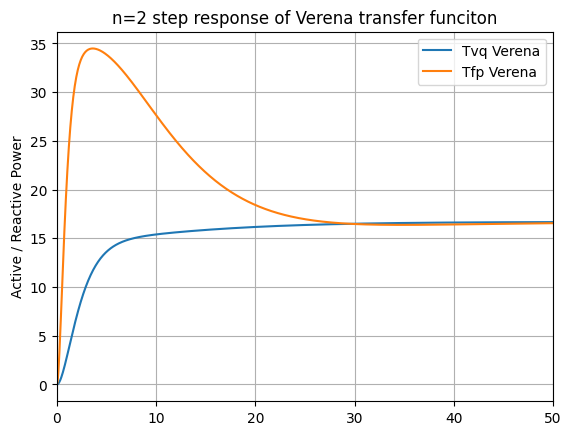

In [401]:
# get transfer function from verena's paper, second order
ss = ct.tf('s')  # create a transfer function variable
Tfcr_verena = 0.2963 / (ss**2 + 0.2667*ss + 0.01778)
# First transfer function T_des,ffr^fp(s, α)
num1 = [143.7, 154.6, 59.75, 7.599, 0]  # numerator coefficients
den1 = [1, 5.17, 9, 6.26, 2.03, 0.3077, 0.0176]  # denominator coefficients
Tffr_verena = ct.TransferFunction(num1, den1)
# Second transfer function T_des^vq(s, α)
num2 = [9.422, 2.56, 0.1897]  # numerator coefficients
den2 = [1, 1.867, 1.084, 0.1991, 0.01137]  # denominator coefficients
Tvq_verena = ct.TransferFunction(num2, den2)
Tfp_verena = Tfcr_verena + Tffr_verena  # FFR + FCR service

# plot verena transfer function
# get step response
tlim = [0, 50]
t = np.linspace(tlim[0], tlim[1], 1000)
t, yvq = ct.step_response(Tvq_verena, T=t)
t, fp = ct.step_response(Tfp_verena, T=t)
plt.plot(t, yvq, label='Tvq Verena')
plt.plot(t, fp, label='Tfp Verena')
plt.legend()
plt.grid()
plt.title('n=2 step response of Verena transfer funciton')
plt.ylabel('Active / Reactive Power')
plt.xlim(tlim)

## Ancillary Service Requirements

In [1093]:
def create_curve(params, t_max, n_points=1000):
    t = np.linspace(0, t_max, n_points)
    v = np.zeros_like(t)
    for (t_start, t_end), (v1, v2) in params.items():
        mask = (t >= t_start) & (t < t_end)
        v[mask] = np.linspace(v1, v2, np.sum(mask))
    return t, v

In [1109]:
# dict with {(t_start, t_end): (v1, v2)}
# FFR
Dp = 0.04
MP_max = 49.167
T_MAX_FFR = 10
require_ffr = {(0, .7): (0, 0), (.7, 5): (1/Dp, 1/Dp), (5, T_MAX_FFR): (1/Dp, 0)}
require_ffr_max = {(0, .7): (0, MP_max), (.7, 5): (MP_max, MP_max), (5, 10): (MP_max, 0)}
ts_ffr_max, input_ffr_max = create_curve(require_ffr_max, t_max=T_MAX_FFR)

# FCR
ti, ta, Dp = 2, 30, 0.06
RP_MAX = 32.56
T_MAX_FCR = 60
require_fcr = {(ti, ta): (0, 1/Dp), (ta, T_MAX_FCR): (1/Dp, 1/Dp)}
require_fcr_max = {(ti, ta): (0, RP_MAX), (ta, T_MAX_FCR): (RP_MAX, RP_MAX)}
ts_fcr_max, input_fcr_max = create_curve(require_fcr_max, t_max=T_MAX_FCR)

## define helpers

In [402]:
# s = ct.tf('s')  # create a transfer function variable
s = sp.symbols('s')  # create a symbolic variable for SymPy

def pade(t, n=2):
    # [n/n] Pade for e^{-t s}: ((1 - s t /(2n))^n)/((1 + s t /(2n))^n)
    if t==0: return 1
    return ((1 - s*t/(2*n))**n) / ((1 + s*t/(2*n))**n)

def Y_segment(yi, yj, ti, tj, n=2):
    # Eq. (11): Y_ij(s) = ((yi - yj)/s + d/s^2) * (e^{-ti s} - e^{-tj s})
    d = (yj - yi) / (tj - ti)
    return (yi + d/s) * pade(ti, n) - (yj + d/s) * pade(tj, n)

def sympy_to_tf(T_sym, s=sp.symbols('s')):
    """
    Convert a SymPy rational function T(s) into a python-control TransferFunction.
    """
    num, den = sp.fraction(sp.together(T_sym))   # separate numerator and denominator
    num_poly = sp.Poly(sp.expand(num), s)
    den_poly = sp.Poly(sp.expand(den), s)

    # coefficients in descending powers of s
    num_coeffs = [float(c) for c in num_poly.all_coeffs()]
    den_coeffs = [float(c) for c in den_poly.all_coeffs()]

    return ct.tf(num_coeffs, den_coeffs)

## FCR control reference

In [404]:
def build_fcr_tf(ti, ta, Dp, n=2, t_final=50,
                 cutoff_mag=[],
                 rm_zeros=False,
                 gain=1) -> ct.TransferFunction:
    t1, t2, t3 = ti, ta, t_final
    y1, y2, y3 = 0, 1.0 / Dp, 1.0 / Dp
    ts = [t1, t2, t3]
    ys = [y1, y2, y3]

    # Build Y(s) with formula 11
    Y = Y_segment(ys[0], ys[1], ts[0], ts[1], n=n)  # first segment
    # Y += Y_segment(ys[1], ys[2], ts[1], ts[2], n=n)  # second segment
    # for i in range(len(ts) - 1):
    #     yi, yj, ti, tj = ys[i], ys[i + 1], ts[i], ts[i + 1]
    #     d = (yj - yi) / (tj - ti)
    #     Y += yi * pade(ti, n) - yj * pade(tj, n) + d/s * (pade(ti, n) - pade(tj, n))
    
    T = sympy_to_tf(sp.simplify(Y))

    # now cut off the poles and zeros that are too low or high in magnitude
    if cutoff_mag!=[]:
        poles = T.poles()
        zeros = T.zeros()
        # Cut off poles
        poles = [p for p in poles if np.abs(p) > cutoff_mag[0] and np.abs(p) < cutoff_mag[1]]
        if rm_zeros:
            zeros = []
        # build new transfer function
        return ct.zpk(zeros, poles, gain)

    return T

In [405]:
Tfcr_des = build_fcr_tf(ti, ta, Dp, n=2, cutoff_mag=[0.08, 1], rm_zeros=True,
                        gain=0.2963)

(0.0, 50.0)

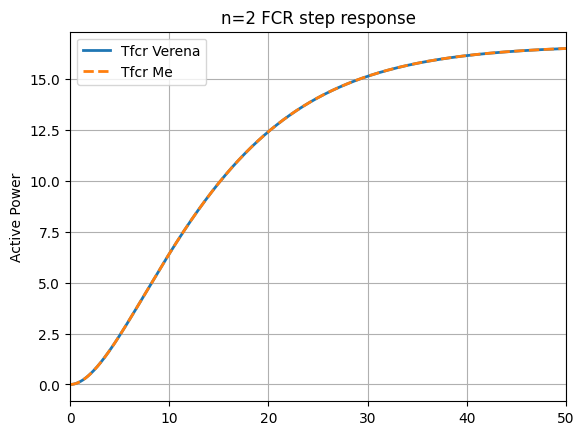

In [406]:
t, yfcr_verena = ct.step_response(Tfcr_verena, T=t)
t, yfcr_des = ct.step_response(Tfcr_des, T=t)
plt.plot(t, yfcr_verena, label='Tfcr Verena', linestyle='-', linewidth=2)
plt.plot(t, yfcr_des, label='Tfcr Me', linestyle='--', linewidth=2)
plt.legend()
plt.grid()
plt.title('n=2 FCR step response')
plt.ylabel('Active Power')
plt.xlim(tlim)

## Voltage Control reference

In [407]:
tvq90, tvq100, Dq = 5, 60, 0.06

In [408]:
import sympy as sp

def build_vq_tf(tvq90, tvq100, Dq, n=2, t_final=1e3,
                cutoff_mag=[],
                 gain=1) -> ct.TransferFunction:
    """
    Construct T_des^vq(s) using the paper's method:
      1) build the unit-step output Y(s) from two linear segments,
      2) then T(s) = s * Y(s),
      3) voltage-control levels: 0 -> 0.9/Dq at tvq90 -> 1/Dq at tvq100.
    n: order of Pade approximation for e^{-t s}.
    Returns a ct.TransferFunction.
    """
    # voltage-control target levels are normalized by Dq
    y1 = 0
    y2 = 0.9 / Dq
    y3, y4 = 1.0 / Dq, 1.0 / Dq
    t1, t2, t3, t4 = 0.0, tvq90, tvq100, t_final
    
    # Build Y(s) from segments
    Y = Y_segment(y1, y2, t1, t2) + Y_segment(y2, y3, t2, t3) + Y_segment(y3, y4, t3, t4)
    T = sympy_to_tf(sp.simplify(Y))

    # quick sanity check: final value of step response must be 1/Dq
    # lim_{s->0} T(s) = 1/Dq
    # assert sp.N(sp.limit(T, s, 0)) == sp.N(1/Dq)
    # now cut off the poles and zeros that are too low or high in magnitude
    if cutoff_mag!=[]:
        poles = T.poles()
        zeros = T.zeros()
        # Cut off poles
        poles = [p for p in poles if np.abs(p) > cutoff_mag[0] and np.abs(p) < cutoff_mag[1]]
        zeros = [z for z in zeros if np.abs(z) > cutoff_mag[0] and np.abs(z) < cutoff_mag[1]]
        # build new transfer function
        return ct.zpk(zeros, poles, gain)

    return T

In [409]:
Tvq_des = build_vq_tf(tvq90, tvq100, Dq, n=2, cutoff_mag = [.1, 1], gain=9)

In [410]:
# compare zeros
cutoff_mag = [.1, 1]
print(Tvq_verena.zeros())
print(Tvq_des.zeros())
print([z for z in Tvq_des.zeros() if np.abs(z) > cutoff_mag[0] and np.abs(z) < cutoff_mag[1]])

[-0.13585226+0.04096209j -0.13585226-0.04096209j]
[-0.1017339+0.03749778j -0.1017339-0.03749778j]
[(-0.10173389538889951+0.037497775976482565j), (-0.10173389538889951-0.037497775976482565j)]


In [411]:
# compare poles
print(Tvq_verena.poles())
print(Tvq_des.poles())
print([p for p in Tvq_des.poles() if np.abs(p) > cutoff_mag[0] and np.abs(p) < cutoff_mag[1]])

[-0.83194602+0.j -0.76800333+0.j -0.13934249+0.j -0.12770816+0.j]
[-0.79999999+0.j -0.80000001+0.j]
[(-0.7999999904586+0j), (-0.8000000095413974+0j)]


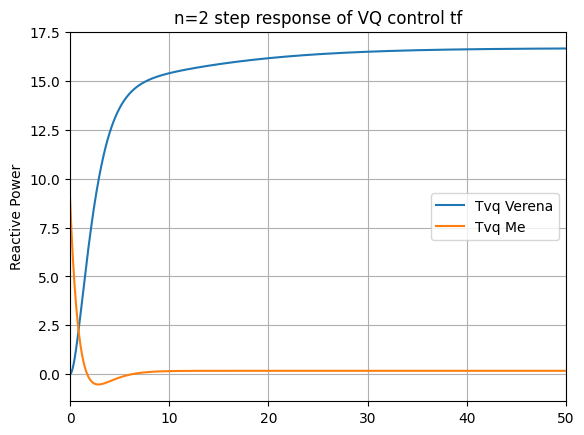

In [412]:
# compare with verena
t, yvq_des = ct.step_response(Tvq_des, T=t)
plt.plot(t, yvq, label='Tvq Verena')
plt.plot(t, yvq_des, label='Tvq Me')
plt.legend()
plt.grid()
plt.title('n=2 step response of VQ control tf')
plt.ylabel('Reactive Power')
plt.xlim(tlim)
yvq_des = yvq

## FFR reference

In [413]:
num_ffr = [143.7, 154.6, 59.75, 7.599, 0]
den_ffr = [1, 5.17, 9, 6.26, 2.03, 0.3077, 0.0176]

Tffr_des = ct.TransferFunction(num_ffr, den_ffr)

_, yffr_des = ct.step_response(Tffr_des, T=t)

yffr_fcr_des = np.add(yfcr_des, yffr_des)

In [414]:
out = yfcr_des + yffr_des

(0.0, 50.0)

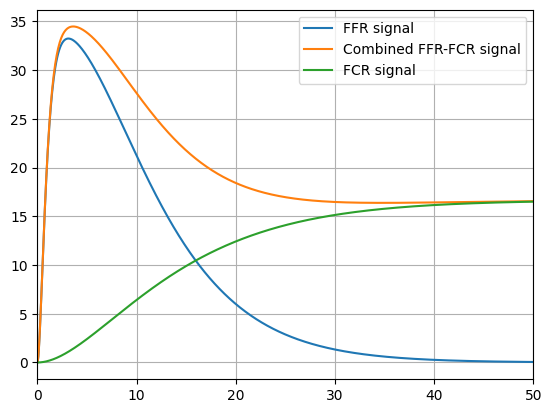

In [415]:
plt.plot(t, yffr_des, label='FFR signal')
plt.plot(t, yffr_fcr_des, label='Combined FFR-FCR signal')
plt.plot(t, yfcr_des, label='FCR signal')
plt.legend()
plt.grid()
plt.xlim(tlim)

# Individual Unit Response to services

## build PI and saturation block

In [1005]:
# set saturation and PI parameters
saturation_limits = 33 * np.array([-1, 1])
KP, KI = 16, 92  # if not specified otherwise
params = {}

In [1006]:
# get sample systems: PV, Wind, BESS
# parameters from https://www.researchgate.net/publication/353419981_Automatic_Load_Frequency_Control_in_an_Isolated_Micro-grid_with_Superconducting_Magnetic_Energy_Storage_Unit_using_Integral_Controller
tau_PV, K_PV = 1.5, 1
tau_WTG, K_WTG = 2, 1
tau_BESS, K_BESS = 0.1, 1
taus = [tau_PV, tau_WTG, tau_BESS]
Kss = [K_PV, K_WTG, K_BESS]

names = ['PV', 'Wind', 'BESS']
# for n in names:
#     params[n] = {"kp": KP, "ki": KI}
params['PV'] = {"kp": 11.9, "ki": 157.9}
params['Wind'] = {"kp": 11.9, "ki": 118}
params['BESS'] = {"kp": 12, "ki": 2370}

Gs = {}  # transfer functions
for tau, K, name in zip(taus, Kss, names):
    G = ct.tf(K, [tau, 1], inputs=['u'], outputs=['y'])
    Gs[name] = G

In [1007]:
# get hydro system from Verena paper
Rg, Rt = 0.03, 0.38
taug, taur, tauw = 0.2, 5, 1

def get_hydro_tf():
    T_hydro = -1/Rg / (taug*s + 1) * (taur*s+1) / (Rt/Rg*taur*s+1) * (1-tauw*s) / (1+1/2*tauw*s)
    return sympy_to_tf(sp.simplify(T_hydro))

T_hydro = get_hydro_tf() * Gs['Wind'] # add typical delay
T_hydro = ct.tf(T_hydro.num, T_hydro.den, inputs=['u'], outputs=['y'])
names.append('Hydro')
Gs['Hydro'] = T_hydro

# set pi params for hydro
# calculated and tuned in matlab
params["Hydro"] = {"kp": -0.0796, "ki": -0.09788}

In [1008]:
# get more advanced wind power model from "Dynamic Virtual Power Plant Design forFast Frequency Reserves: Coordinating Hydro and Wind" at https://www.research-collection.ethz.ch/server/api/core/bitstreams/208b9ae8-95ba-4bbf-abdb-c21a0c496068/content
# wind_speed = 10  # example wind speed in m/s, below maximum power (note: Gotthard wind turbine the avg. wind speed is 11.8 m/s accoring to Global Wind Atlas)
# zbar = 5.8 * wind_speed * 1e-3

# def get_wind_zp_tf():
#     T_wind_advanced = (s - zbar) / (s + zbar) #ct.tf([1, -zbar], [1, zbar], inputs=['u'], outputs=['y'])
#     return sympy_to_tf(sp.simplify(T_wind_advanced))

# T_wind_advanced = get_wind_zp_tf() * Gs['Wind'] # add typical delay
# T_wind_advanced = ct.tf(T_wind_advanced.num, T_wind_advanced.den, inputs=['u'], outputs=['y'])

# names.append('Wind (Adv)')
# Gs['Wind (Adv)'] = T_wind_advanced

# # set pi params
# params["Wind (Adv)"] = {"kp": KP, "ki": KI}

In [ ]:
# def first_order_constraint(params):
#     """
#     builds a first order system with energy constraints

#     params: dict with at least:
#             'tau': time constant
#             'theta' (dc gain),   
#             'E_max' (maximum energy)
#     """
#     # Create a first order system
#     # G = ct.TransferFunction([dc_gain], [tau, 1])  # linear model
    
#     # state update
    # def updfcn(t, x, u, params={}):
    #     tau = params.get('tau')

    #     # Update states
    #     x0 = - 1/tau * x[0] + u[0]        # np.clip(u[0], -np.inf, E_max - x[1])
    #     x1 = x[0]                  # energy state

    #     return [x0, x1]

    # # output
    # def output(t, x, u, params={}):
    #     E_max, tau, theta = params.get('E_max'), params.get('tau'), params.get('theta')
    #     out = np.where(x[1]>=E_max, 0, 1)  # apply max energy limits
    #     return 1/tau * theta * x[0] * out

    # G = ct.nlsys(
    #     updfcn,
    #     output,
    #     inputs=['u'], outputs=['y'], states=['x0', 'x1'],
    #     params=params
    # )
    # return G

In [1070]:
# create supercapacitor system
tau_SC = 0.01  # tau_SC taken from Verena's paper
p_sc = {'tau': tau_SC, 'E_max': .05}  # maximum energy

def sc_update(t, x, u, params={}):
    # Get maximum energy of supercapacitor
    E_max = params.get('E_max')
    tau = params.get('tau', tau_SC)

    # Update states
    x0 = - 1/tau * x[0] + u[0]        # np.clip(u[0], -np.inf, E_max - x[1])
    x1 = x[0] #+ x[1]                  # energy state
    #     keep_mask = x==50
    # out = np.where(x>50,0,1)
    # out[keep_mask] = 50
    # apply physical limits
    # x0 = np.clip(x0, -np.inf, E_max - x1)

    return [x0, x1]

def sc_output(t, x, u, params={}):
    tau = params.get('tau', tau_SC)
    E_max = params.get('E_max')
    out = np.where(x[1]>=E_max, 1, 0)  # apply max energy limits
    return 1/tau * x[0] * (1 - out)

Gs['SC'] = ct.NonlinearIOSystem(
    sc_update,
    sc_output,
    inputs=['u'], outputs=['y'], states=['xsc0', 'xsc1'],
    params=p_sc
)

if 'SC' not in names: names.append('SC')

# set pi params for hydro
params["SC"] = {"kp": KP, "ki": KI}

now get the closed looped systems

In [1071]:
def pi_update(t, x, u, params={}):
    # Get the controller parameters that we need
    kp = params.get('kp')
    ki = params.get('ki', 0.1)
    kaw = params.get('kaw', 15 * ki)  # anti-windup gain

    err = u[0]   # error signal
    z = x[0]     # integrated error

    # Compute unsaturated output
    u_a = kp * err + ki * z

    # Compute anti-windup compensation (scale by ki to account for structure)
    u_aw = kaw/ki * (u_a - np.clip(u_a, saturation_limits[0], saturation_limits[1])) if ki != 0 else 0

    # State is the integrated error, minus anti-windup compensation
    return err - u_aw

def pi_output(t, x, u, params={}):
    # Get the controller parameters that we need
    kp = params.get('kp')
    ki = params.get('ki')

    # Assign variables for inputs and states (for readability)
    err = u[0]  # error signal
    z = x[0]    # integrated error

    # PI controller with saturation
    return np.clip(kp * err + ki * z, saturation_limits[0], saturation_limits[1]) # account for saturation

def get_pi_controller(params):
    # old: without saturation
    # return ct.tf(
    #     [params['kp'], params['ki']], [1, 0],
    #     inputs=['e'], outputs=['u']
    # )
    return ct.NonlinearIOSystem(
        pi_update, pi_output, name='control',
        inputs=['e'], outputs=['u'], states=['z'],
        params=params)

PIs = {name: get_pi_controller(params=params[name]) for name in names}

# define error signal
error = ct.summing_junction(['yref', '-y'], 'e')

# define u, e as output as well
u_out = ct.summing_junction(['u'], 'u_out')
err_out = ct.summing_junction(['e'], 'err_out')

# create closed-loop systems
Closed_Loop_systems = {name: ct.interconnect([PIs[name], Gs[name], error, u_out, err_out], inputs=['yref'], outputs=['y', 'u_out', 'err_out']) for name in names}

In [1072]:
Closed_Loop_systems

{'PV': <InterconnectedSystem:sys[2691]:['yref']->['y', 'u_out', 'err_out']>,
 'Wind': <InterconnectedSystem:sys[2693]:['yref']->['y', 'u_out', 'err_out']>,
 'BESS': <InterconnectedSystem:sys[2695]:['yref']->['y', 'u_out', 'err_out']>,
 'Hydro': <InterconnectedSystem:sys[2697]:['yref']->['y', 'u_out', 'err_out']>,
 'SC': <InterconnectedSystem:sys[2698]:['yref']->['y', 'u_out', 'err_out']>}

## Start Plotting

In the plots below, I tuned the PI controllers of the respective plants (PV, Wind, BESS, Hydro, Supercap) very aggresively (via standard PI-tuning methods). The results show that individual devices are most often not capable of following the desired transfer function for FCR, FFR and VQ control, even though the saturation limits are set above the reference. This means that the characteristics of the individual devices deny them taking part in the dynamic ancillary services. This motivates them to cooperate.

In [1114]:
def check_control_system(Gs: list, vref, names: list, title='', tlim=tlim,
                         check_diff=False, t_diff=1,
                         print_total_energy=False,
                         plot_hard_constrains={}):
    """
    Check the performance of the control system.
    Gs: list of interconnected system
    vref: reference to follow

    check_error: specify error range to be checked for Gs response to vref
        .1 -> 10% error
        and return true or false

    diff_dict: dict for names satisfying requirements

    print_total_energy: print_total_energy

    plot_hard_constrains: plot hard constraints of reference in fromat {(t1, t2): (v1, v2), ...}
    """
    t = np.linspace(tlim[0], tlim[1], 1000)   
    # Initial conditions: [PI integrator state, system state]
    x0 = [0, 0]

    # Plot results
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plt.plot(t, vref, 'r--', label='Reference', linewidth=2)

    if check_diff:
        lower_bound, upper_bound = vref * (1 - check_diff), vref * (1 + check_diff)
        mask = t >= t_diff
        plt.fill_between(t[mask], lower_bound[mask], upper_bound[mask], color='red', alpha=0.2, label=f'±{check_diff * 100}% Tolerance')
    
    # plot star at hard constraints
    some_counter = 0
    for (t_start, t_end), (v1, v2) in plot_hard_constrains.items():
        # at first point, plot a star
        if some_counter==0:
            plt.plot(t_start, v1, '*',  color='orange', markersize=5)
            plt.plot([t_start, t_end], [v1, v2], color='orange', linewidth=1, label='Min Hard Constraint')
            some_counter += 1
        else:
            plt.plot(t_start, v1, '*',  color='orange', markersize=5)
            plt.plot([t_start, t_end], [v1, v2], color='orange', linewidth=1)
        

    j = 0
    name = names[j]
    diff_dict = {}  # dictionary for satisfying requirements

    for closed_loop in Gs:
        name = names[j]
        # Simulate the closed-loop response
        response = ct.input_output_response(closed_loop, t, vref, x0)
    
        # Extract outputs and states properly
        plant_output = response.outputs[0] if response.outputs.ndim > 1 else response.outputs
        # pi_state = response.states[0] if response.states.ndim > 1 else response.states
        # pv_state = response.states[1] if response.states.ndim > 1 and response.states.shape[0] > 1 else response.states

        plt.subplot(2, 1, 1)
        plt.plot(t, plant_output, linewidth=1.5, label=f'{name}')

        if print_total_energy:
            energy = np.trapz(plant_output, x=t)
            print(f'Total Energy for {name}: {energy:.2f}')

        # second plot
        plt.subplot(2, 1, 2)
        UNIT_NAMES = name.split('+')
        if len(UNIT_NAMES) > 1:
            UNITS = response.outputs.shape[0] - 1
            for k in range(1, UNITS+1):
                plt.plot(t, response.outputs[k], '--', label=f'{UNIT_NAMES[k-1]} PI Output u{k}')
        else:
            plt.plot(t, response.outputs[1], '--', label=f'{name} PI Output u')
        # plt.plot(t, response.outputs[1], '--', label=f'{name} PI Output u')  # plot input, e.g. output of PI controller
        

        # Print some performance metrics
        print(f"Metrics for {name}:")
        final_output = plant_output[-1] if hasattr(plant_output, '__len__') else plant_output
        steady_state_error = abs(vref[-1] - final_output)
        print(f"Steady-state error: {steady_state_error:.4f}")
    
        # Find settling time (within 2% of final value)
        if hasattr(plant_output, '__len__') and len(plant_output) > 1:
            final_value = plant_output[-1]
            settling_idx = np.where(np.abs(plant_output - final_value) <= 0.02 * abs(final_value))[0]
            if len(settling_idx) > 0:
                settling_time = t[settling_idx[0]]
                print(f"Settling time (2%): {settling_time:.2f} seconds")
            
            # Check for overshoot
            if final_value!=0:
                max_output = np.max(plant_output)
                overshoot = max(0, (max_output - final_value) / final_value * 100)
                print(f"Overshoot: {overshoot:.2f}%")
        else:
            print("Cannot compute performance metrics - output is scalar")

        if check_diff:
            # find indices where t >= t_diff
            idx = np.where(t >= t_diff)[0][0]
            diff = np.abs((plant_output[idx:] - vref[idx:]) / vref[idx:])

            fulfill_requirements = np.all(diff <= check_diff)

            print(f"Fulfill requirements ({check_diff * 100}%): {fulfill_requirements}")
            diff_dict[name] = fulfill_requirements

        j += 1
        print('========================================')

    plt.subplot(2, 1, 1)
    plt.legend()
    plt.title(title)
    plt.grid(True)
    plt.xlabel('Time [s]')
    plt.ylabel('Output')
    plt.xlim(tlim)

    plt.subplot(2, 1, 2)
    plt.xlabel('Time [s]')
    plt.ylabel('U')
    plt.xlim(tlim)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    plt.show()
    if check_diff:
        return diff_dict

## Step Response

Total Energy for PV: 97.57
Metrics for PV:
Steady-state error: 0.0002
Settling time (2%): 0.54 seconds
Overshoot: 6.25%
Total Energy for Wind: 96.76
Metrics for Wind:
Steady-state error: 0.0002
Settling time (2%): 0.71 seconds
Overshoot: 6.24%
Total Energy for BESS: 99.84
Metrics for BESS:
Steady-state error: 0.0009
Settling time (2%): 0.06 seconds
Overshoot: 4.58%
Total Energy for Hydro: 80.38
Metrics for Hydro:
Steady-state error: 8.3217
Settling time (2%): 9.50 seconds
Overshoot: 0.00%
Total Energy for SC: 4.99
Metrics for SC:
Steady-state error: 10.0000
Settling time (2%): 0.00 seconds


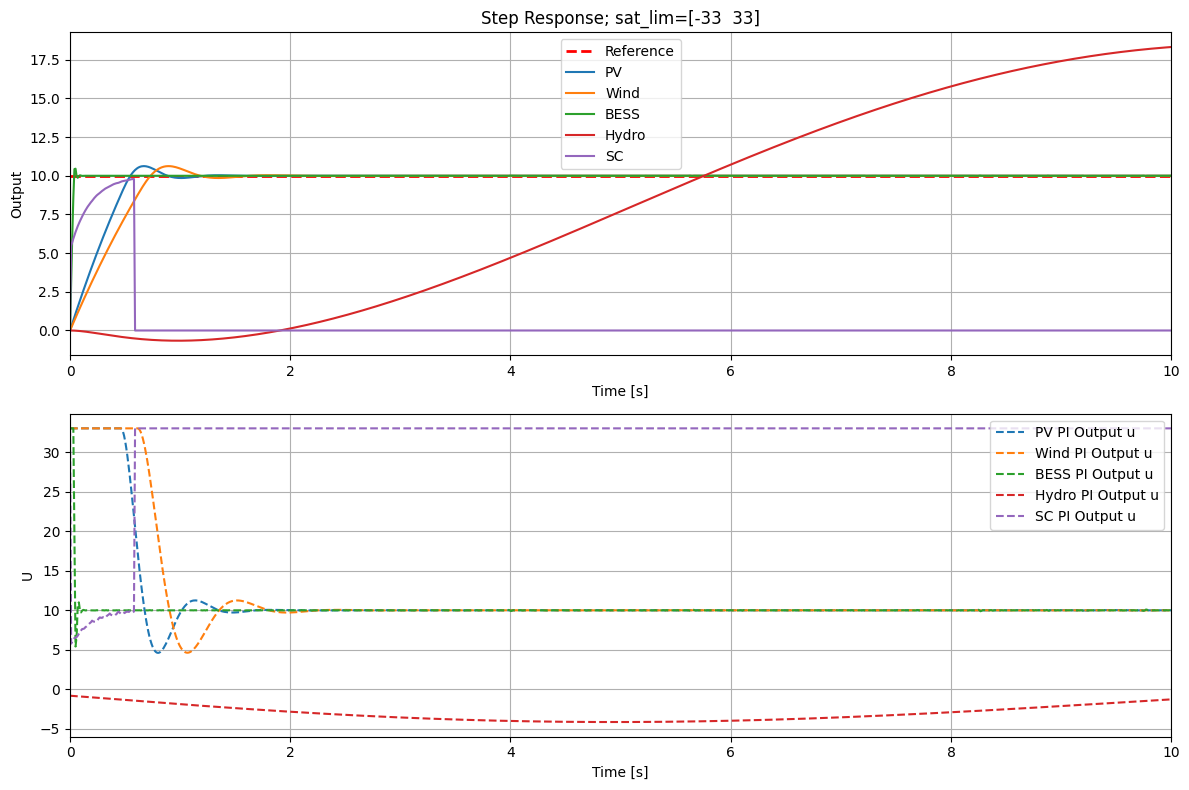

In [1074]:
# check step response but times 10 cause of sizing
step_reference = 10 * np.ones_like(t)
check_control_system(Closed_Loop_systems.values(), step_reference, names, tlim=[0,10], title=f'Step Response; sat_lim={saturation_limits}',
                     print_total_energy=True)

## VQ Response

Metrics for PV:
Steady-state error: 0.0003
Settling time (2%): 4.77 seconds
Overshoot: 0.00%
Fulfill requirements (5.0%): True
Metrics for Wind:
Steady-state error: 0.0001
Settling time (2%): 4.77 seconds
Overshoot: 0.00%
Fulfill requirements (5.0%): True
Metrics for BESS:
Steady-state error: 0.0001
Settling time (2%): 4.74 seconds
Overshoot: 0.03%
Fulfill requirements (5.0%): True
Metrics for Hydro:
Steady-state error: 12.2278
Settling time (2%): 9.71 seconds
Overshoot: 0.00%
Fulfill requirements (5.0%): False
Metrics for SC:
Steady-state error: 16.6642
Settling time (2%): 0.00 seconds
Fulfill requirements (5.0%): False


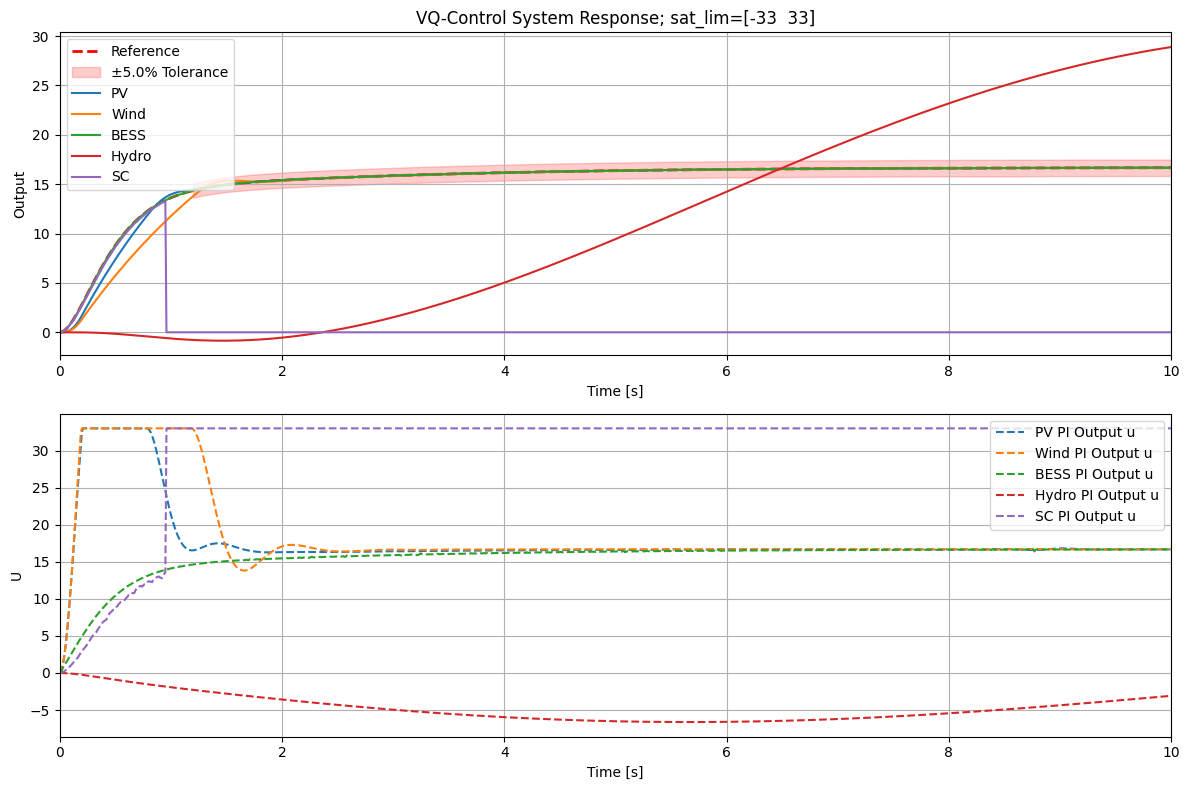

In [986]:
diff_dict = check_control_system(Closed_Loop_systems.values(), yvq, names, tlim=[0,10], title=f'VQ-Control System Response; sat_lim={saturation_limits}',
                     check_diff=0.05, t_diff=1.2)

## FCR response

check if devices can match FCR

Metrics for PV:
Steady-state error: 30.1975
Settling time (2%): 27.45 seconds
Overshoot: 7.91%
Metrics for Wind:
Steady-state error: 30.7811
Settling time (2%): 27.93 seconds
Overshoot: 5.99%
Metrics for BESS:
Steady-state error: 4.7452
Settling time (2%): 6.07 seconds
Overshoot: 587.26%
Metrics for Hydro:
Steady-state error: 33.9103
Settling time (2%): 31.83 seconds
Overshoot: 9.63%


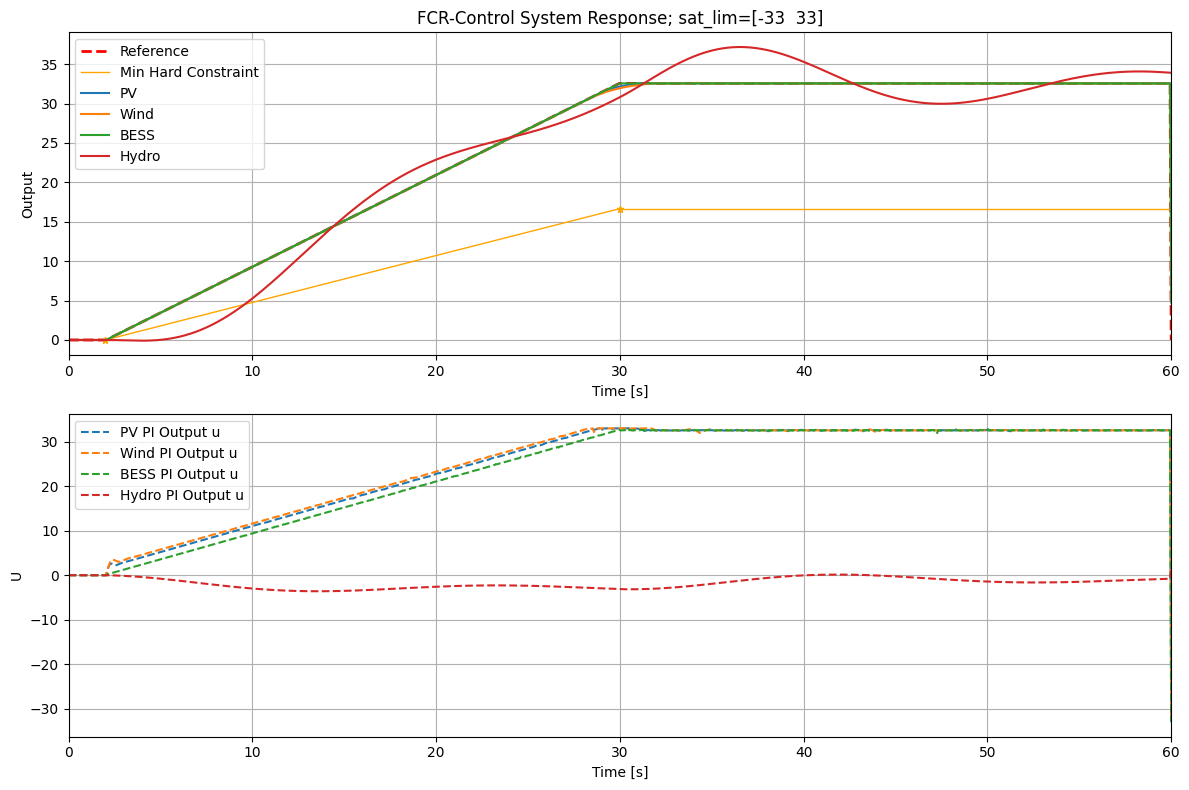

In [1115]:
# # check_control_system(closed_loop, yfcr_verena, title="Response to FCR Signal Input")
# check_control_system(Closed_Loop_systems.values(), yfcr_verena, names, tlim=[0, 60], title=f'FCR-Control System Response; sat_lim={saturation_limits}',
#                     #   check_diff=0.1, t_diff=7,
#                       plot_hard_constrains=require_fcr)
check_control_system(Closed_Loop_systems.values(), input_fcr_max, names, tlim=[0, T_MAX_FCR], title=f'FCR-Control System Response; sat_lim={saturation_limits}',
                      plot_hard_constrains=require_fcr)

## FFR Response

Metrics for PV:
Steady-state error: 0.0350
Settling time (2%): 10.00 seconds
Overshoot: 0.00%
Metrics for Wind:
Steady-state error: 0.0145
Settling time (2%): 10.00 seconds
Overshoot: 0.00%
Metrics for BESS:
Steady-state error: 0.0349
Settling time (2%): 10.00 seconds
Overshoot: 0.00%
Metrics for Hydro:
Steady-state error: 79.2974
Settling time (2%): 8.55 seconds
Overshoot: 1.28%


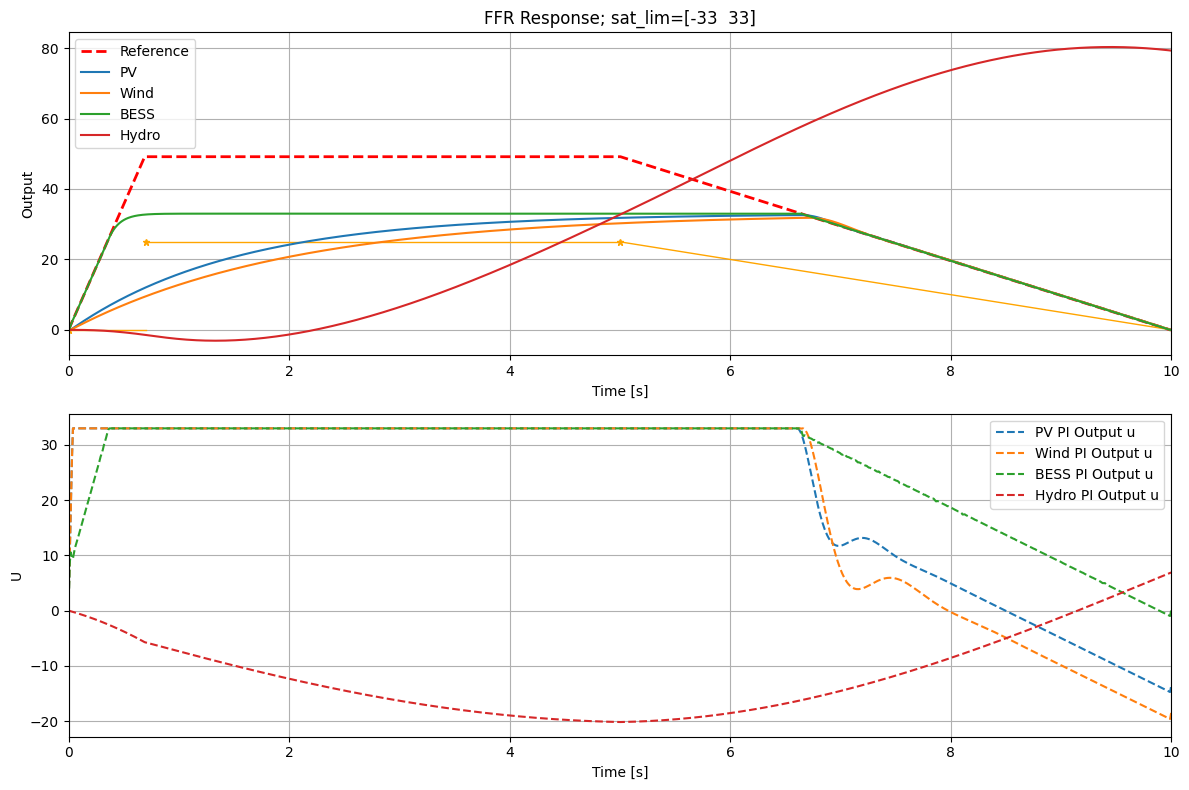

In [1113]:
# check_control_system(Closed_Loop_systems.values(), yffr_des, names, tlim=[0, T_MAX_FFR], title=f'FFR Response; KP={KP}, KI={KI}, sat_lim={saturation_limits}',
#                      plot_hard_constrains=require_ffr)
check_control_system(Closed_Loop_systems.values(), input_ffr_max, names, tlim=[0, T_MAX_FFR], title=f'FFR Response; sat_lim={saturation_limits}',
                     plot_hard_constrains=require_ffr)

## FFR-FCR Response

Metrics for PV:
Steady-state error: 0.0004
Settling time (2%): 1.03 seconds
Overshoot: 28.02%
Metrics for Wind:
Steady-state error: 0.0008
Settling time (2%): 1.37 seconds
Overshoot: 17.63%
Metrics for BESS:
Steady-state error: 0.0006
Settling time (2%): 2.55 seconds
Overshoot: 98.65%
Metrics for Hydro:
Steady-state error: 1.6707
Settling time (2%): 4.94 seconds
Overshoot: 0.00%


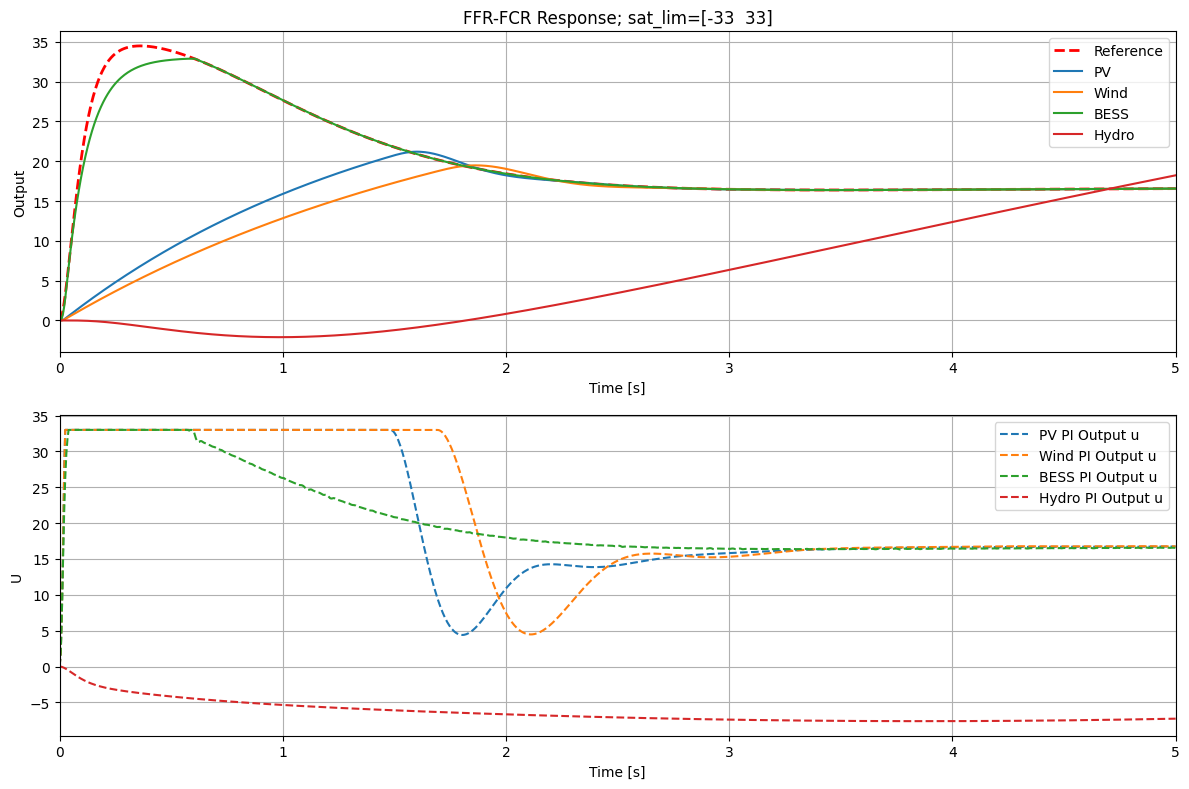

In [808]:
check_control_system(Closed_Loop_systems.values(), yffr_fcr_des, names, tlim=[0,5], title=f'FFR-FCR Response; sat_lim={saturation_limits}')

# DVPP with static participation factors

Here, I implement static participation factors from Verena's papaer *Control Design of Dynamic Virtual Power Plants: An
Adaptive Divide-and-Conquer Approach*

In [755]:
# example: Solar PV LPF, Wind LPF and Battery HPF with same capacity
lpf_devices = {'PV': Gs['PV'], 'Wind': Gs['Wind']}
bpf_devices = {}
hpf_devices = {'BESS': Gs['BESS']}
my_names = ['PV', 'Wind', 'BESS']
tau_c = 0   # 0.081

In [756]:
def DVPP_2_devices(lpf_devices, bpf_devices, hpf_devices):
    mks = {}
    Gs_sum = ct.tf([0], [1])
    for name, g in lpf_devices.items():
        mks[name] = g  # Define steady-state ADPFs as LPFs
        Gs_sum += g
    for name, g in bpf_devices.items():
        mks[name] = g * (g - Gs_sum)   # Fix intermediate ADPFs as BPFs
        Gs_sum += g
    for name, g in hpf_devices.items():
        mks[name] = ct.tf([1], [tau_c, 1]) - Gs_sum   # Fix fastest device’s ADPF as HPF
    # return mks, Gs_sum

    # next, build the system assuming 2 devices
    name1, name2 = list(mks.keys())[:2]
    G1, G2 = Gs[name1], Gs[name2]
    # rename for new closed loop
    G1.output_labels = ['y1']
    G1.name = name1
    G2.output_labels = ['y2']
    G2.name = name2
    # error = ct.summing_junction(['yref', '-y'], 'e')  # error signal
    error1 = ct.summing_junction(['y1ref', '-y1'], 'e1')  # error signal
    error2 = ct.summing_junction(['y2ref', '-y2'], 'e2')  # error signal
    # each plant has their own desired transfer function, namely mks[name] from y -> y_i
    T1_des = ct.tf(mks[name1].num, mks[name1].den, inputs=['yref'], outputs=['y1ref'])
    T2_des = ct.tf(mks[name2].num, mks[name2].den, inputs=['yref'], outputs=['y2ref'])

    y_total = ct.summing_junction(['y1', 'y2'], 'y')  # create new total output

    PI1, PI2 = PIs[name1], PIs[name2]  # get PI controller
    PI1.output_labels = ['u1']
    PI1.input_labels = ['e1']
    PI1.name = f'PI_{name1}'
    PI2.output_labels = ['u2']
    PI2.input_labels = ['e2']
    PI2.name = f'PI_{name2}'
    G1.input_labels = ['u1']
    G2.input_labels = ['u2']

    closed_loop_agg = ct.interconnect([PI1, PI2, G1, G2, y_total, error1, error2, T1_des, T2_des], inputs=['yref'], outputs=['y', 'u1', 'u2'])
    name_agg = f'{name1} + {name2}'

    return closed_loop_agg, name_agg

In [757]:
bess_pv_cl, name_agg = DVPP_2_devices(lpf_devices, bpf_devices, hpf_devices)

Metrics for PV + Wind:
Steady-state error: 16.5668
Settling time (2%): 1.58 seconds
Overshoot: 2.76%
Fulfill requirements (4.0%): False


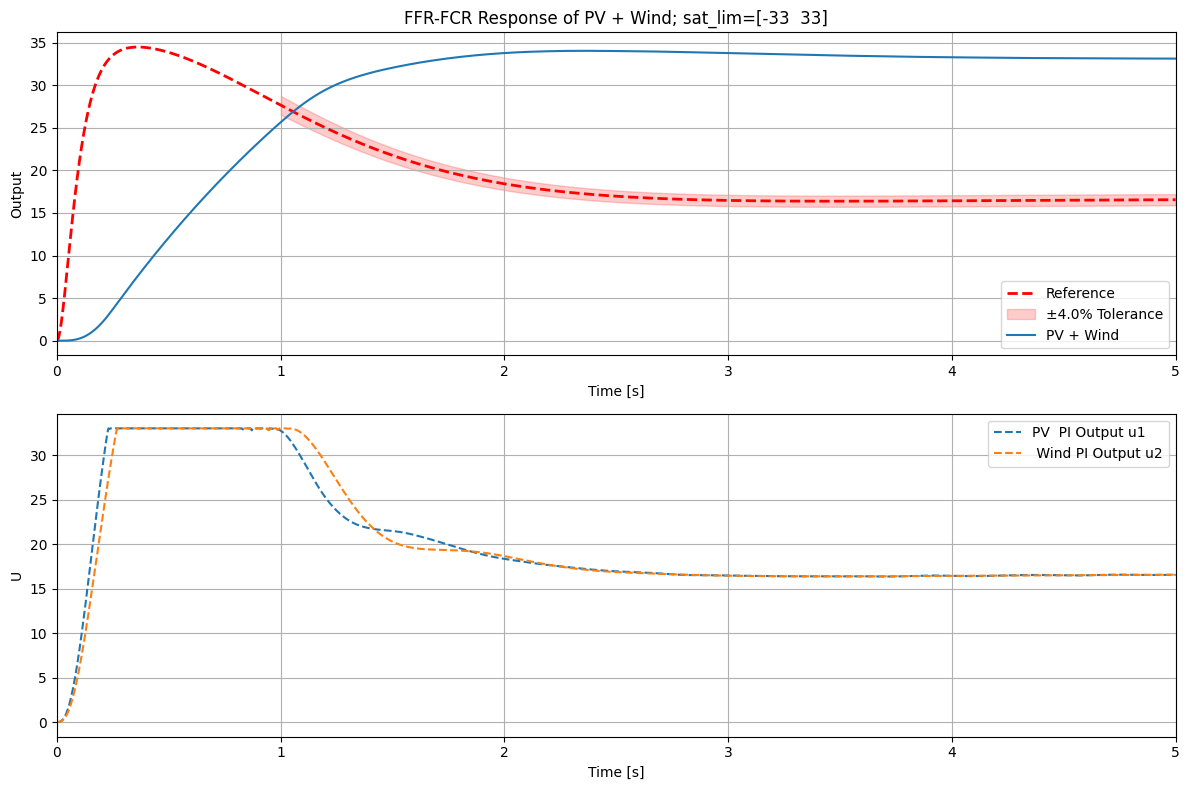

{'PV + Wind': False}

In [758]:
check_control_system([bess_pv_cl], yffr_fcr_des, [name_agg], tlim=[0,5], title=f'FFR-FCR Response of {name_agg}; sat_lim={saturation_limits}',
                     check_diff=.04, t_diff=1)

In [778]:
# do same for 3 devices
def DVPP_3_devices(lpf_devices, bpf_devices, hpf_devices):
    """
    assume 3 devices are connected in parallel
    """
    mks = {}
    Gs_sum = ct.tf([0], [1])
    # assume static and same capacity, thus theta_i is:
    theta_i = 1 / len(lpf_devices)
    for name, g in lpf_devices.items():
        mks[name] = theta_i * g  # Define steady-state ADPFs as LPFs
        Gs_sum += theta_i * g
    for name, g in bpf_devices.items():
        mks[name] = g * (g - Gs_sum)   # Fix intermediate ADPFs as BPFs
        Gs_sum += theta_i * g
    for name, g in hpf_devices.items():
        mks[name] = ct.tf([1], [tau_c, 1]) - Gs_sum   # Fix fastest device’s ADPF as HPF
    # return mks, Gs_sum

    # next, build the system assuming 3 devices
    name1, name2, name3 = list(mks.keys())[:3]
    G1, G2, G3 = Gs[name1], Gs[name2], Gs[name3]
    # rename for new closed loop
    G1.output_labels = ['y1']
    G1.name = name1
    G1.input_labels = ['u1']
    G2.output_labels = ['y2']
    G2.name = name2
    G2.input_labels = ['u2']
    G3.output_labels = ['y3']
    G3.name = name3
    G3.input_labels = ['u3']
    # get PI controller
    PI1, PI2, PI3 = PIs[name1], PIs[name2], PIs[name3]  # get PI controller
    PI1.output_labels = ['u1']
    PI1.input_labels = ['e1']
    PI1.name = f'PI_{name1}'
    PI2.output_labels = ['u2']
    PI2.input_labels = ['e2']
    PI2.name = f'PI_{name2}'
    PI3.output_labels = ['u3']
    PI3.input_labels = ['e3']
    PI3.name = f'PI_{name3}'
    # get error signals
    error1 = ct.summing_junction(['y1ref', '-y1'], 'e1')  # error signal
    error2 = ct.summing_junction(['y2ref', '-y2'], 'e2')  # error signal
    error3 = ct.summing_junction(['y3ref', '-y3'], 'e3')  # error signal
    # each plant has their own desired transfer function, namely mks[name] from y -> y_i
    T1_des = ct.tf(mks[name1].num, mks[name1].den, inputs=['yref'], outputs=['y1ref'])
    T2_des = ct.tf(mks[name2].num, mks[name2].den, inputs=['yref'], outputs=['y2ref'])
    T3_des = ct.tf(mks[name3].num, mks[name3].den, inputs=['yref'], outputs=['y3ref'])

    y_total = ct.summing_junction(['y1', 'y2', 'y3'], 'y')  # create new total output

    closed_loop_agg = ct.interconnect([PI1, PI2, PI3, G1, G2, G3, y_total, error1, error2, error3, T1_des, T2_des, T3_des], inputs=['yref'], outputs=['y', 'u1', 'u2', 'u3'])
    name_agg = f'{name1} + {name2} + {name3}'

    return closed_loop_agg, name_agg

Metrics for PV:
Steady-state error: 0.0004
Settling time (2%): 1.03 seconds
Overshoot: 28.02%
Fulfill requirements (4.0%): False


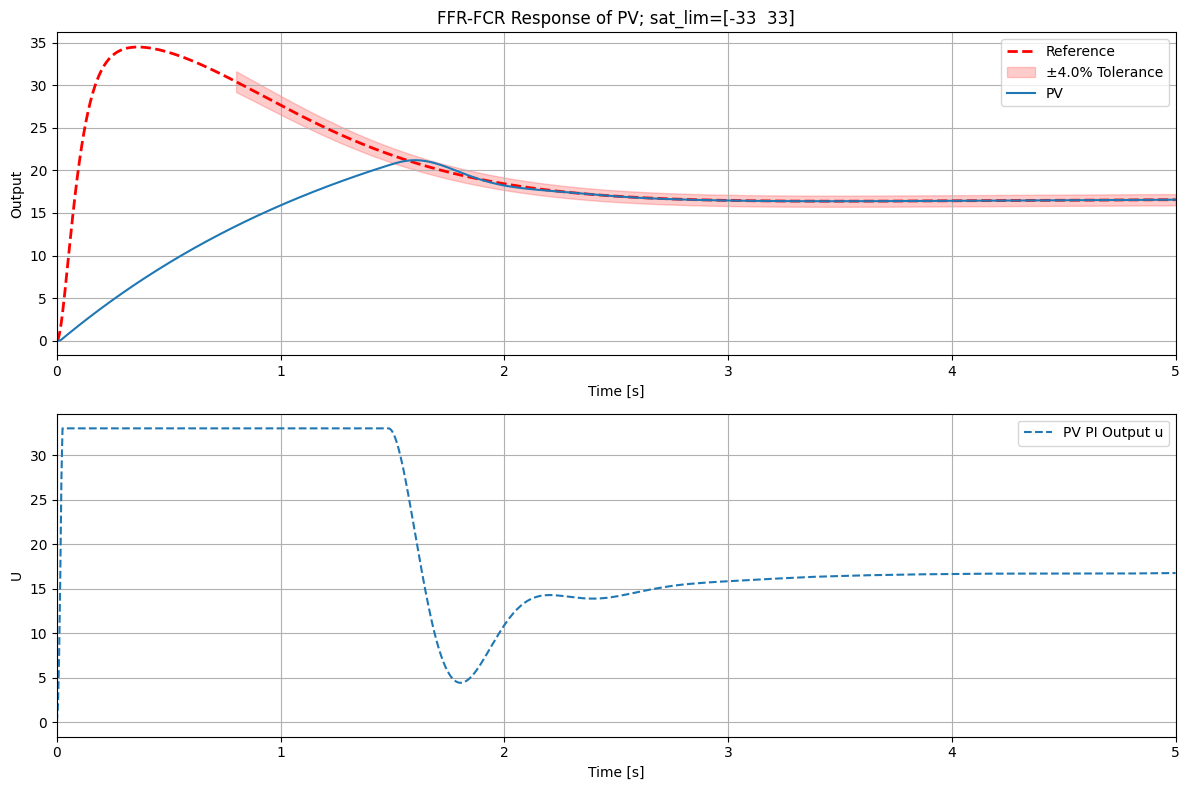

Metrics for Wind:
Steady-state error: 0.0008
Settling time (2%): 1.37 seconds
Overshoot: 17.63%
Fulfill requirements (4.0%): False


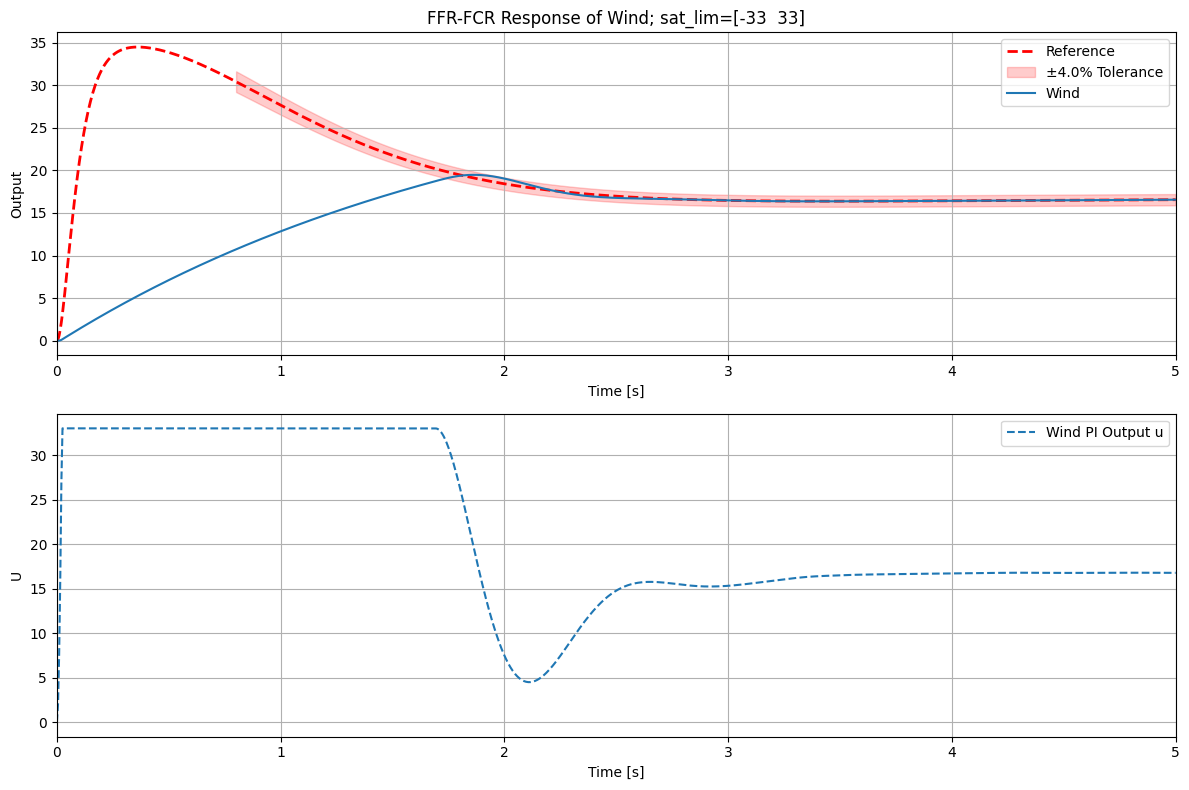

Metrics for BESS:
Steady-state error: 0.0006
Settling time (2%): 2.55 seconds
Overshoot: 98.65%
Fulfill requirements (4.0%): True


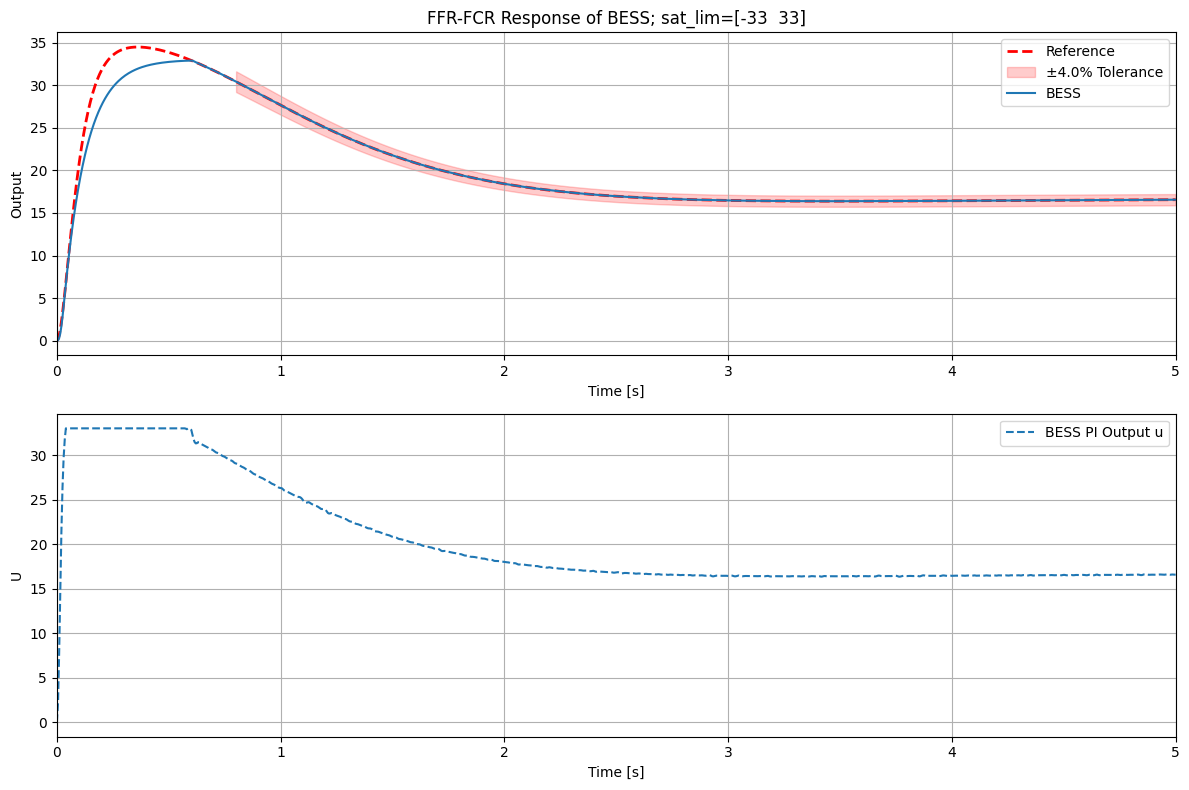

Metrics for PV + Wind:
Steady-state error: 16.5668
Settling time (2%): 1.58 seconds
Overshoot: 2.76%
Fulfill requirements (4.0%): False


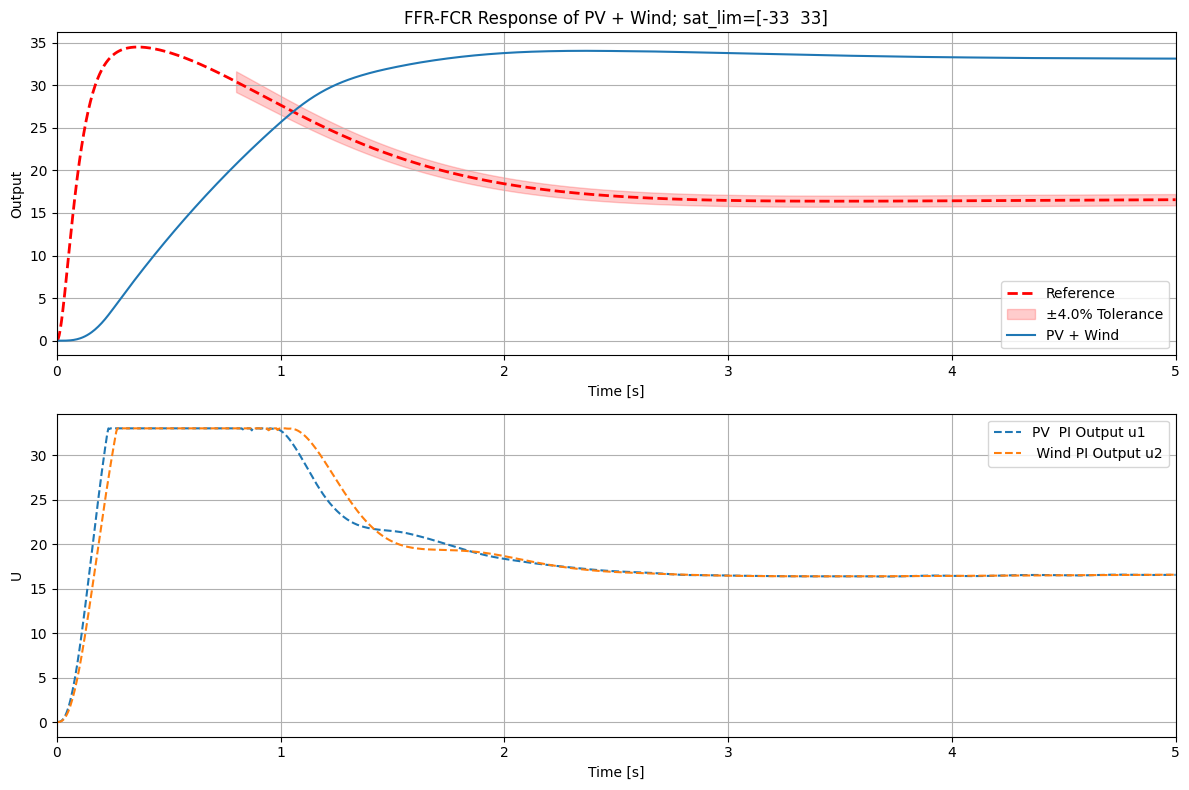

Metrics for PV + BESS:
Steady-state error: 0.0008
Settling time (2%): 0.09 seconds
Overshoot: 101.89%
Fulfill requirements (4.0%): True


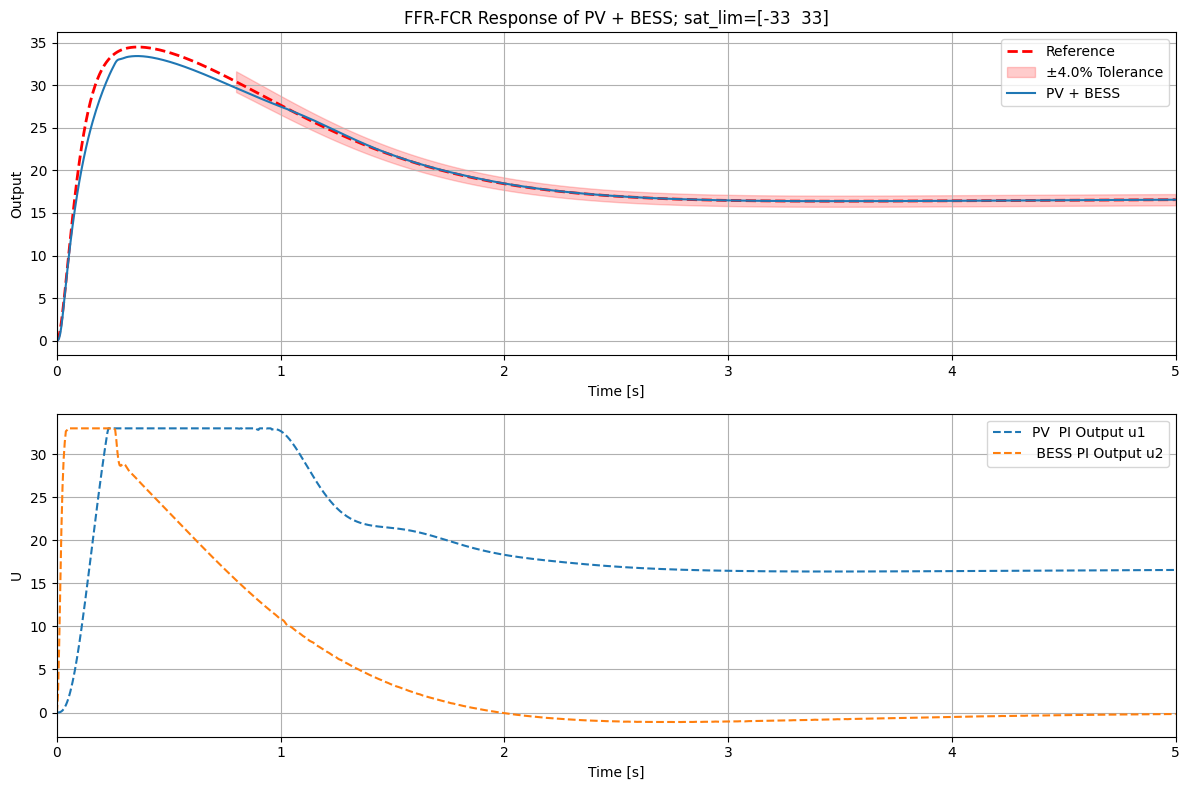

Metrics for Wind + BESS:
Steady-state error: 0.0011
Settling time (2%): 0.09 seconds
Overshoot: 101.29%
Fulfill requirements (4.0%): True


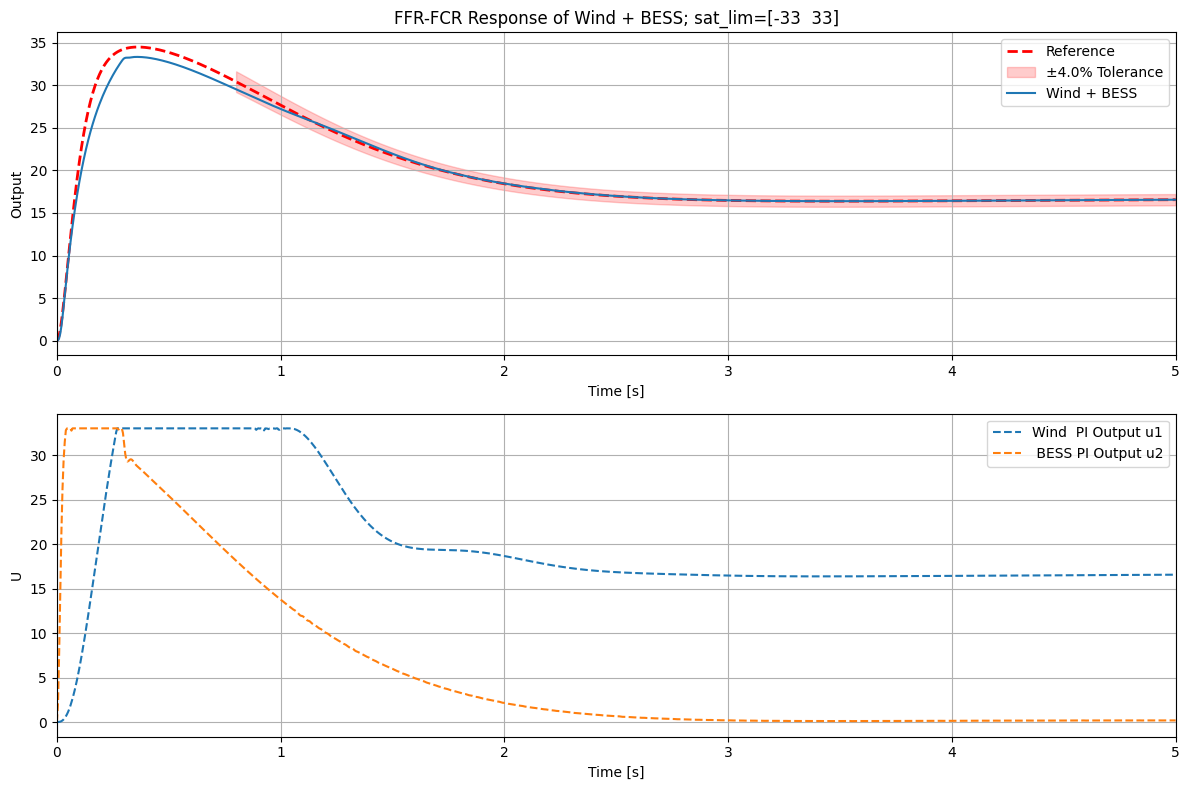

Metrics for PV + Wind + BESS:
Steady-state error: 0.0008
Settling time (2%): 0.09 seconds
Overshoot: 105.26%
Fulfill requirements (4.0%): True


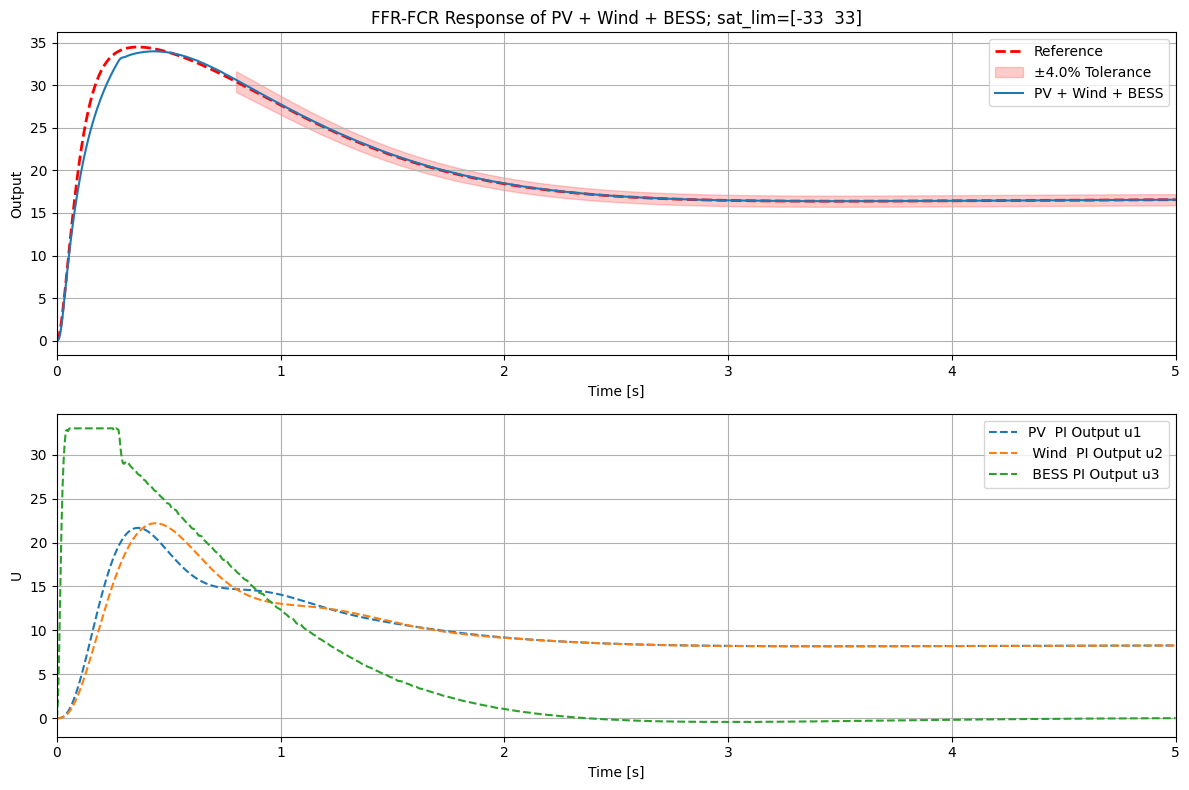

In [779]:
# run for FFR-FCR control
import itertools

# create value function
VALUE = {}

for name in my_names:
    # check if fulfills requirements
    g_cl = Closed_Loop_systems[name]
    dict_out = check_control_system([g_cl], yffr_fcr_des, [name], tlim=[0,5], title=f'FFR-FCR Response of {name}; sat_lim={saturation_limits}',
                         check_diff=.04, t_diff=.8)
    VALUE[(name)] = dict_out[name]

for subset in itertools.combinations(my_names, 2):
    g_cl, name = DVPP_2_devices(lpf_devices={k: Gs[k] for k in subset if k in lpf_devices}, 
                          bpf_devices={k: Gs[k] for k in subset if k in bpf_devices}, 
                          hpf_devices={k: Gs[k] for k in subset if k in hpf_devices})
    dict_out = check_control_system([g_cl], yffr_fcr_des, [name], tlim=[0,5], title=f'FFR-FCR Response of {name}; sat_lim={saturation_limits}',
                                     check_diff=.04, t_diff=.8)
    VALUE[(subset)] = dict_out[name]

for subset in itertools.combinations(my_names, 3):
    g_cl, name = DVPP_3_devices(lpf_devices={k: Gs[k] for k in subset if k in lpf_devices}, 
                          bpf_devices={k: Gs[k] for k in subset if k in bpf_devices}, 
                          hpf_devices={k: Gs[k] for k in subset if k in hpf_devices})
    dict_out = check_control_system([g_cl], yffr_fcr_des, [name], tlim=[0,5], title=f'FFR-FCR Response of {name}; sat_lim={saturation_limits}',
                                     check_diff=.04, t_diff=.8)
    VALUE[(subset)] = dict_out[name]

In [780]:
for key, value in VALUE.items():
    # convert True/False to 1/0 float
    VALUE[key] = 1.0 if value else 0.0
VALUE

{'PV': 0.0,
 'Wind': 0.0,
 'BESS': 1.0,
 ('PV', 'Wind'): 0.0,
 ('PV', 'BESS'): 1.0,
 ('Wind', 'BESS'): 1.0,
 ('PV', 'Wind', 'BESS'): 1.0}

In [781]:
import math as mt

In [782]:
# shapely value of coalition

def get_shapely_value(v: dict, players: list) -> dict:
    """
    Shapley value calculation for a coalition game.

    v: Characteristic function of the game, must be defined for EVERY coalition
        {dict -> float}
    players: list of players
    """
    shapley_values = {p: 0 for p in players}  # empty coaltion: 0 value
    n = len(players)
    # iterate over all coalitions
    for c_size in range(1, len(players) + 1):  # iterate over coalition sizes
        for subset in itertools.combinations(players, c_size):
            k = len(subset)
            for p in subset:  # iterate over player in subset
                marginal_contribution = v.get(subset, 0) - v.get(tuple(c for c in subset if c != p), 0)
                shapley_values[p] += marginal_contribution * mt.factorial(k - 1) * mt.factorial(n - k) / mt.factorial(n)

    return shapley_values

In [783]:
get_shapely_value(VALUE, my_names)

{'PV': 0.16666666666666666,
 'Wind': 0.16666666666666666,
 'BESS': 0.6666666666666666}

### DVPP for VQ control

In [ ]:
# run for FFR-FCR control
import itertools

# create value function
VALUE = {}

for name in my_names:
    # check if fulfills requirements
    g_cl = Closed_Loop_systems[name]
    dict_out = check_control_system([g_cl], yffr_fcr_des, [name], tlim=[0,5], title=f'FFR-FCR Response of {name}; sat_lim={saturation_limits}',
                         check_diff=.04, t_diff=.8)
    VALUE[(name)] = dict_out[name]

for subset in itertools.combinations(my_names, 2):
    g_cl, name = DVPP_2_devices(lpf_devices={k: Gs[k] for k in subset if k in lpf_devices}, 
                          bpf_devices={k: Gs[k] for k in subset if k in bpf_devices}, 
                          hpf_devices={k: Gs[k] for k in subset if k in hpf_devices})
    dict_out = check_control_system([g_cl], yffr_fcr_des, [name], tlim=[0,5], title=f'FFR-FCR Response of {name}; sat_lim={saturation_limits}',
                                     check_diff=.04, t_diff=.8)
    VALUE[(subset)] = dict_out[name]

for subset in itertools.combinations(my_names, 3):
    g_cl, name = DVPP_3_devices(lpf_devices={k: Gs[k] for k in subset if k in lpf_devices}, 
                          bpf_devices={k: Gs[k] for k in subset if k in bpf_devices}, 
                          hpf_devices={k: Gs[k] for k in subset if k in hpf_devices})
    dict_out = check_control_system([g_cl], yffr_fcr_des, [name], tlim=[0,5], title=f'VQ Response of {name}; sat_lim={saturation_limits}',
                                     check_diff=.04, t_diff=.8)
    VALUE[(subset)] = dict_out[name]

# Aggregated Unit responses

## Aggr. 2 units

Metrics for PV + Wind:
Steady-state error: 0.0004
Settling time (2%): 0.50 seconds
Overshoot: 67.65%


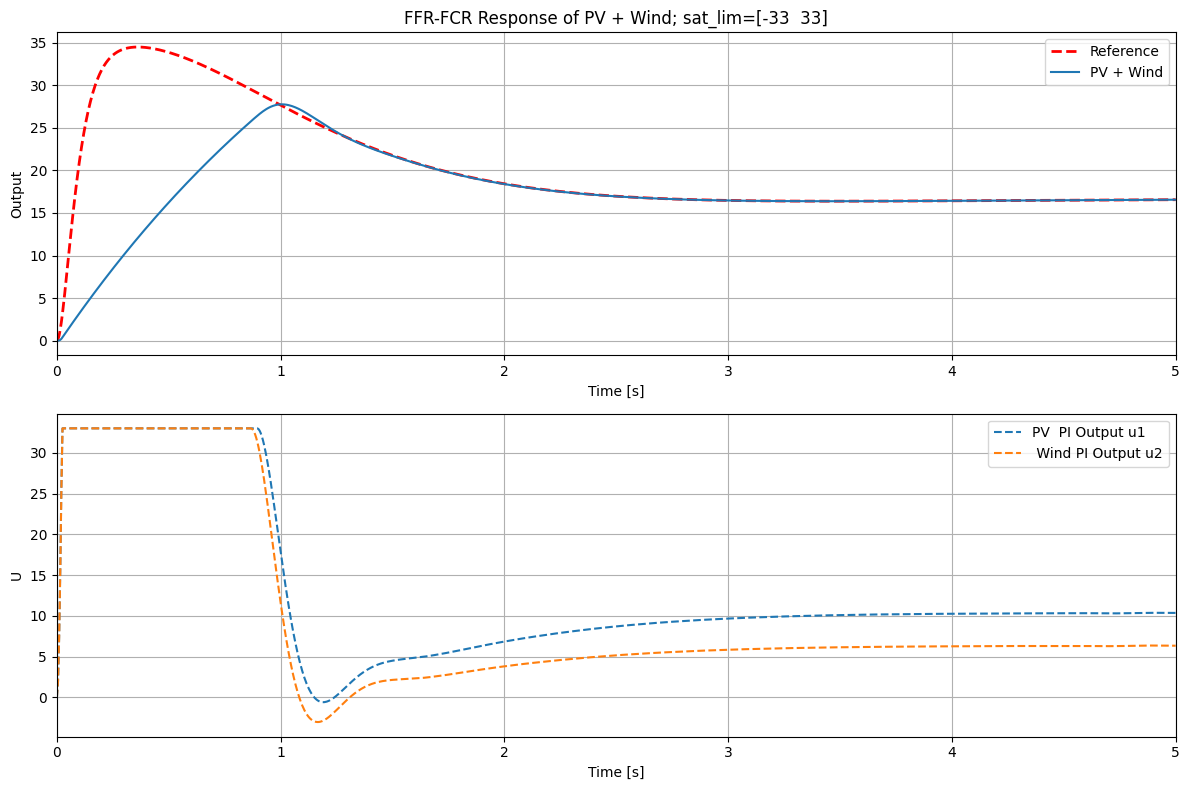

Metrics for PV + Wind:
Steady-state error: 0.0007
Settling time (2%): 2.38 seconds
Overshoot: 0.00%


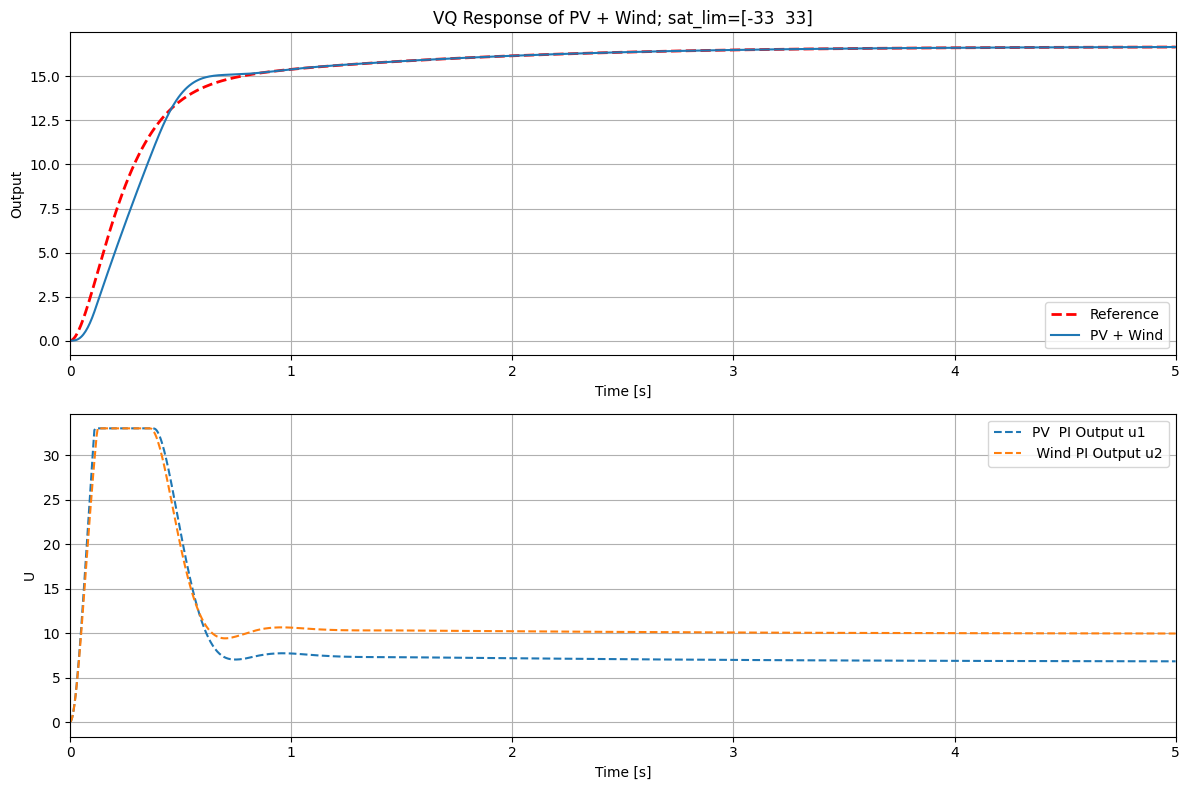

Metrics for PV + BESS:
Steady-state error: 0.0001
Settling time (2%): 0.09 seconds
Overshoot: 108.34%


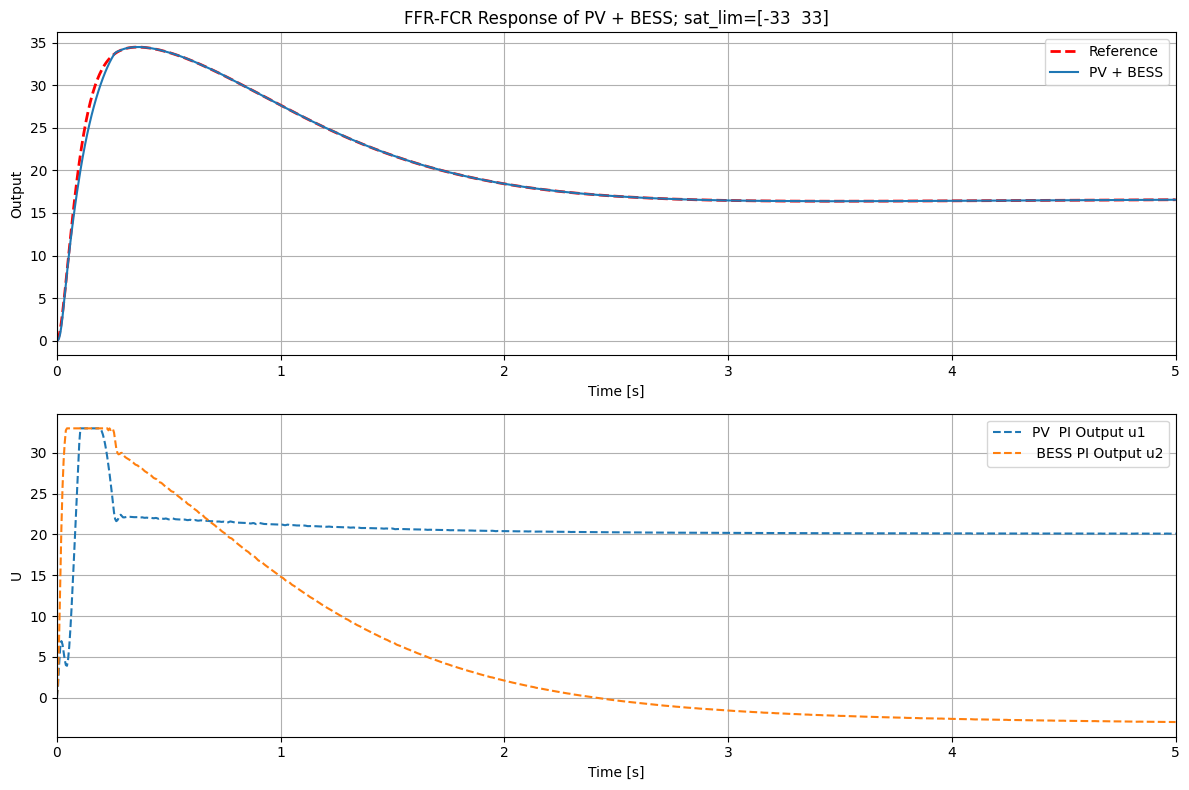

Metrics for PV + BESS:
Steady-state error: 0.0011
Settling time (2%): 2.38 seconds
Overshoot: 0.03%


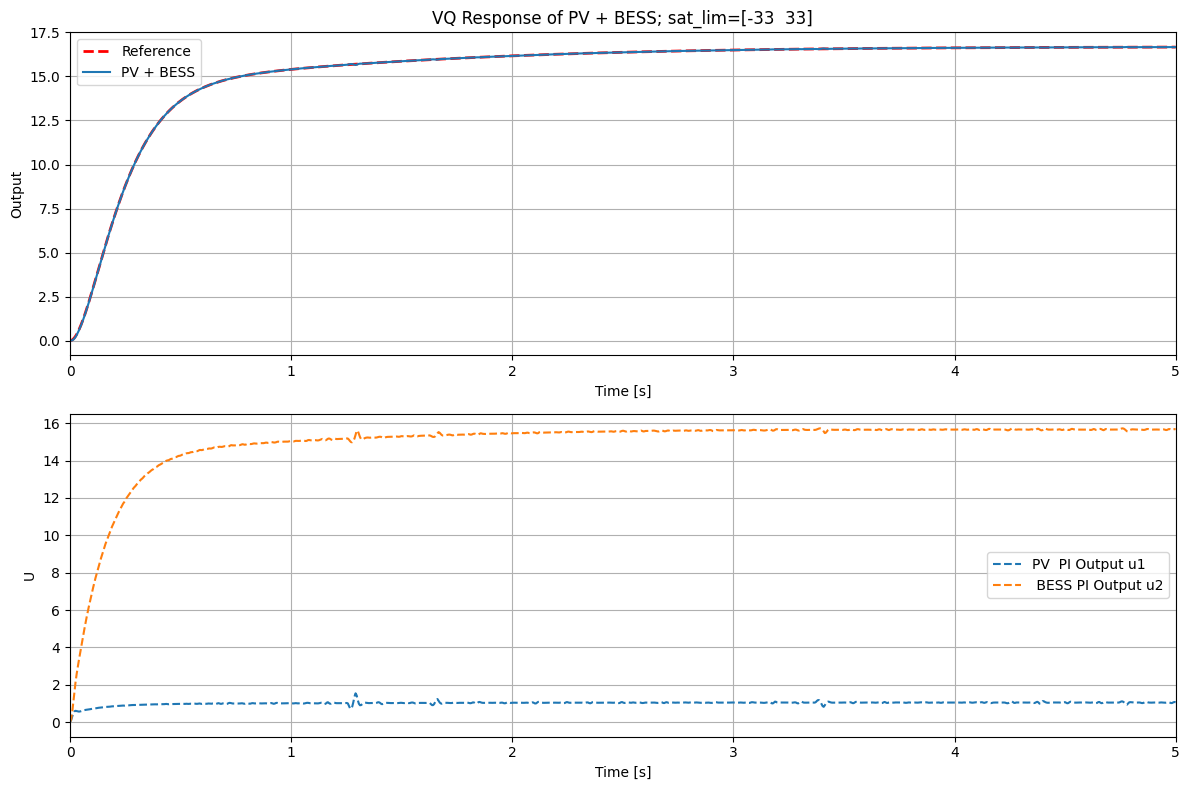

Metrics for PV + Hydro:
Steady-state error: 0.0082
Settling time (2%): 1.14 seconds
Overshoot: 28.57%


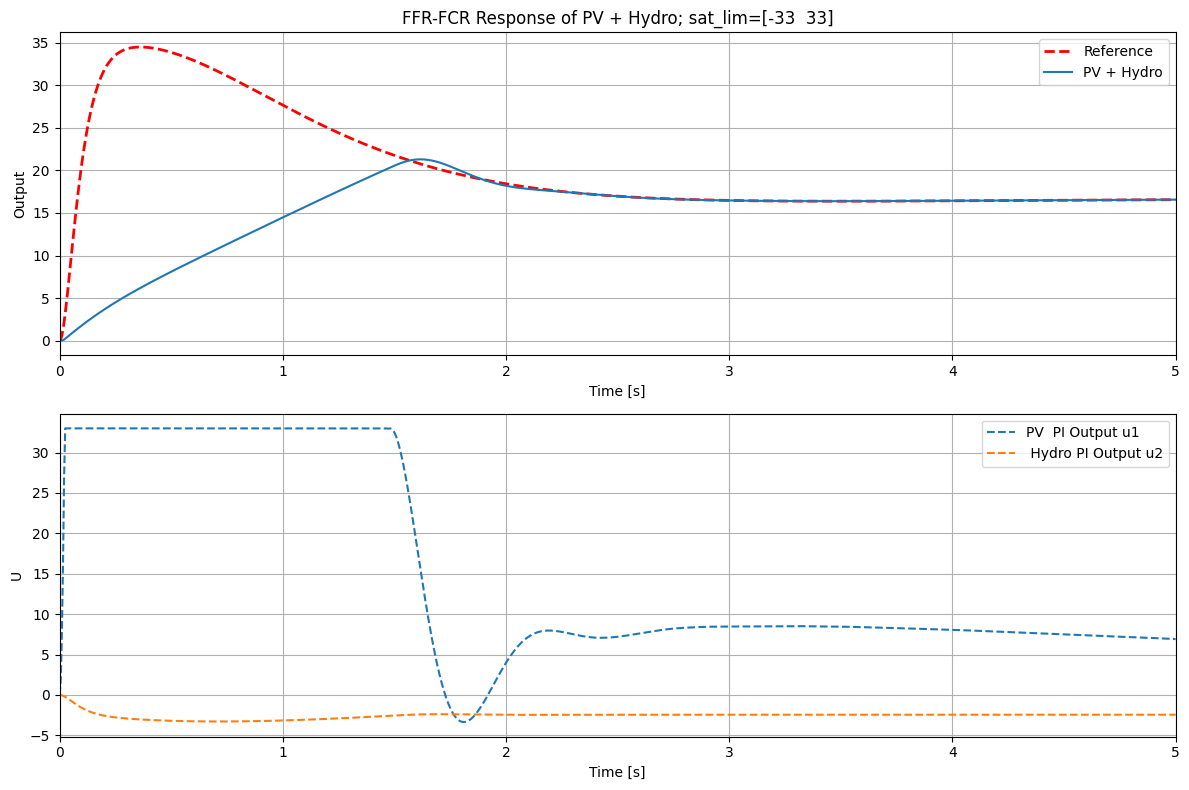

Metrics for PV + Hydro:
Steady-state error: 0.0012
Settling time (2%): 2.39 seconds
Overshoot: 0.00%


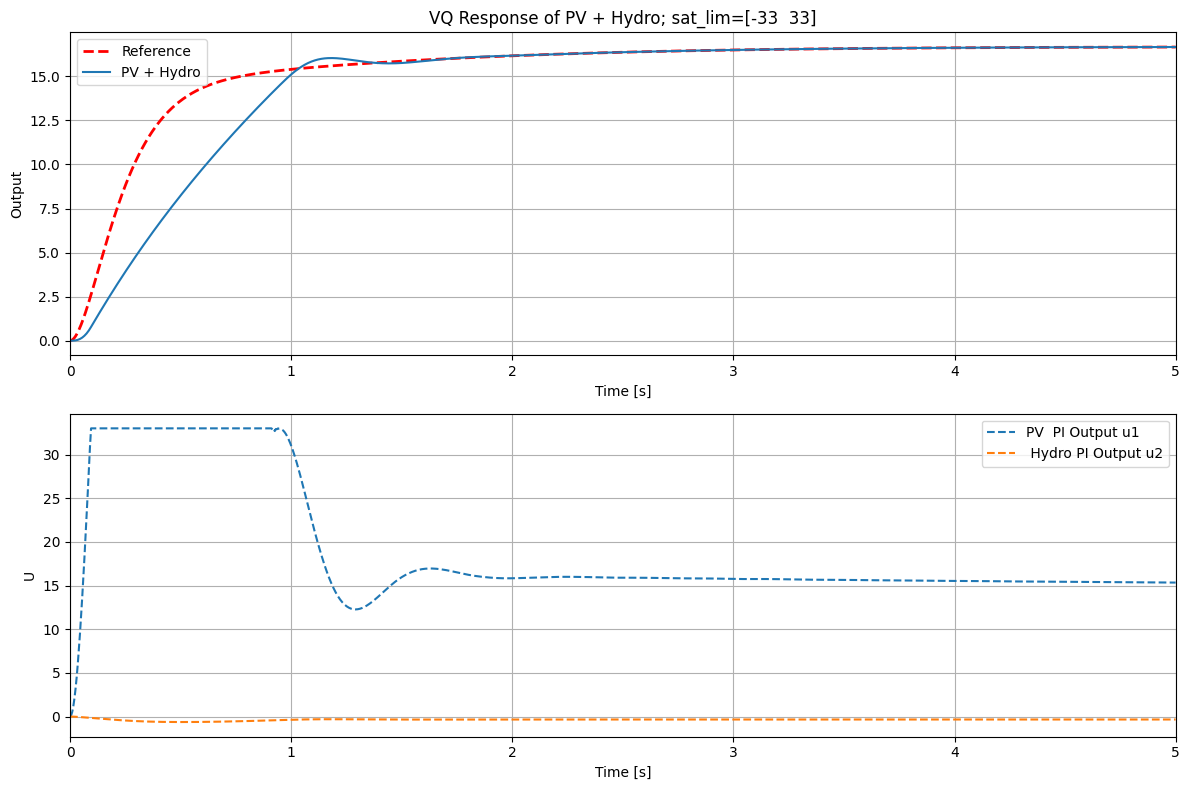

Metrics for Wind + BESS:
Steady-state error: 0.0002
Settling time (2%): 0.09 seconds
Overshoot: 108.61%


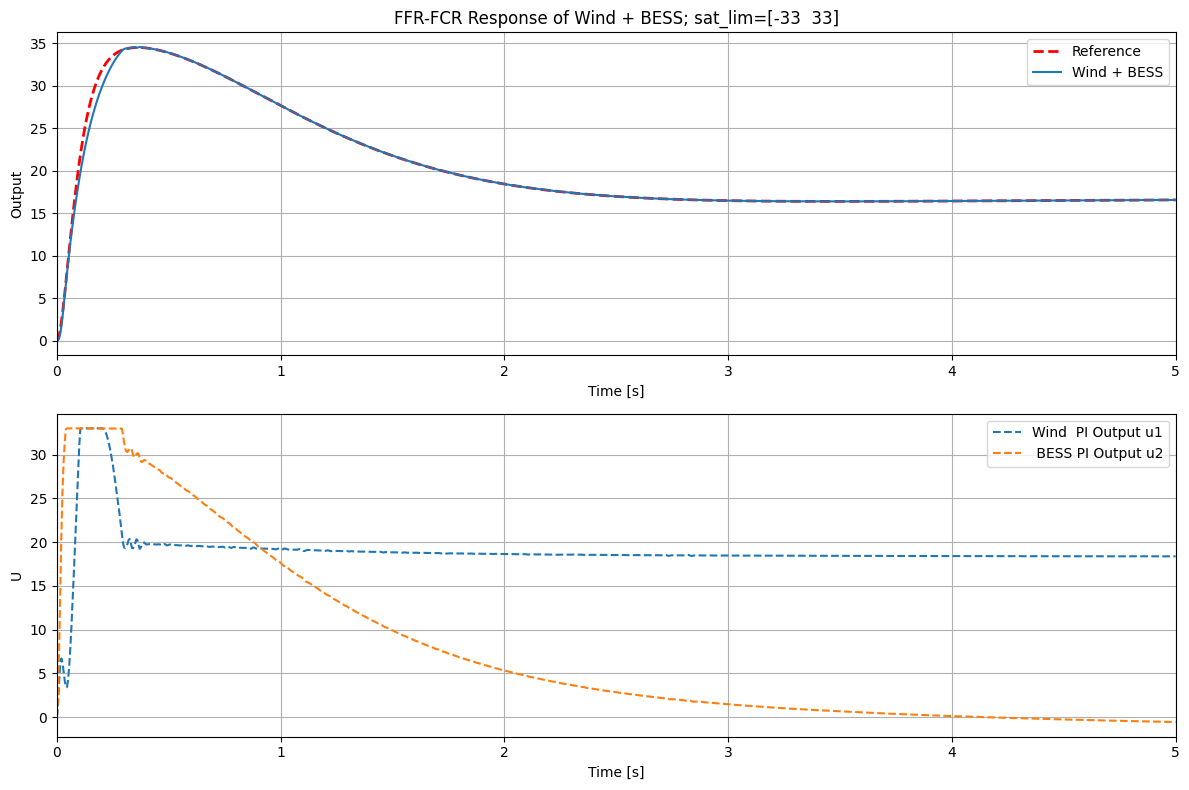

Metrics for Wind + BESS:
Steady-state error: 0.0001
Settling time (2%): 2.39 seconds
Overshoot: 0.01%


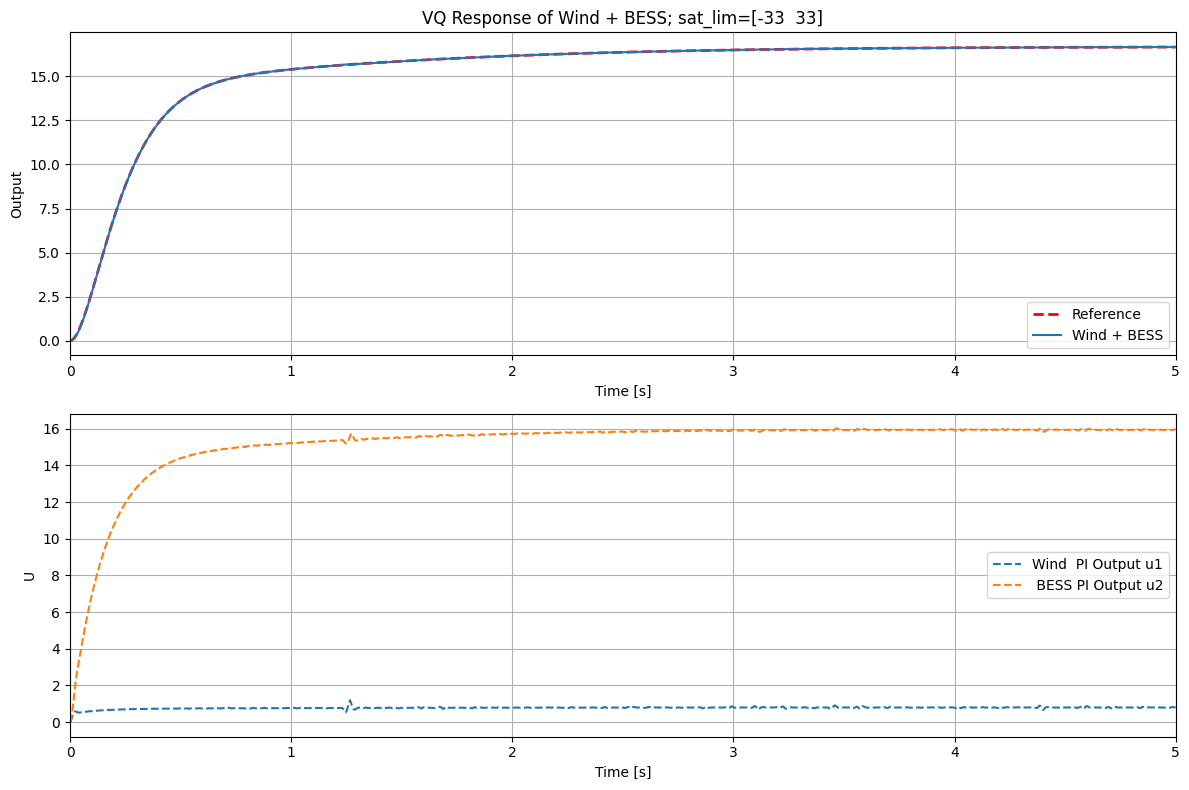

Metrics for Wind + Hydro:
Steady-state error: 0.0113
Settling time (2%): 1.44 seconds
Overshoot: 20.18%


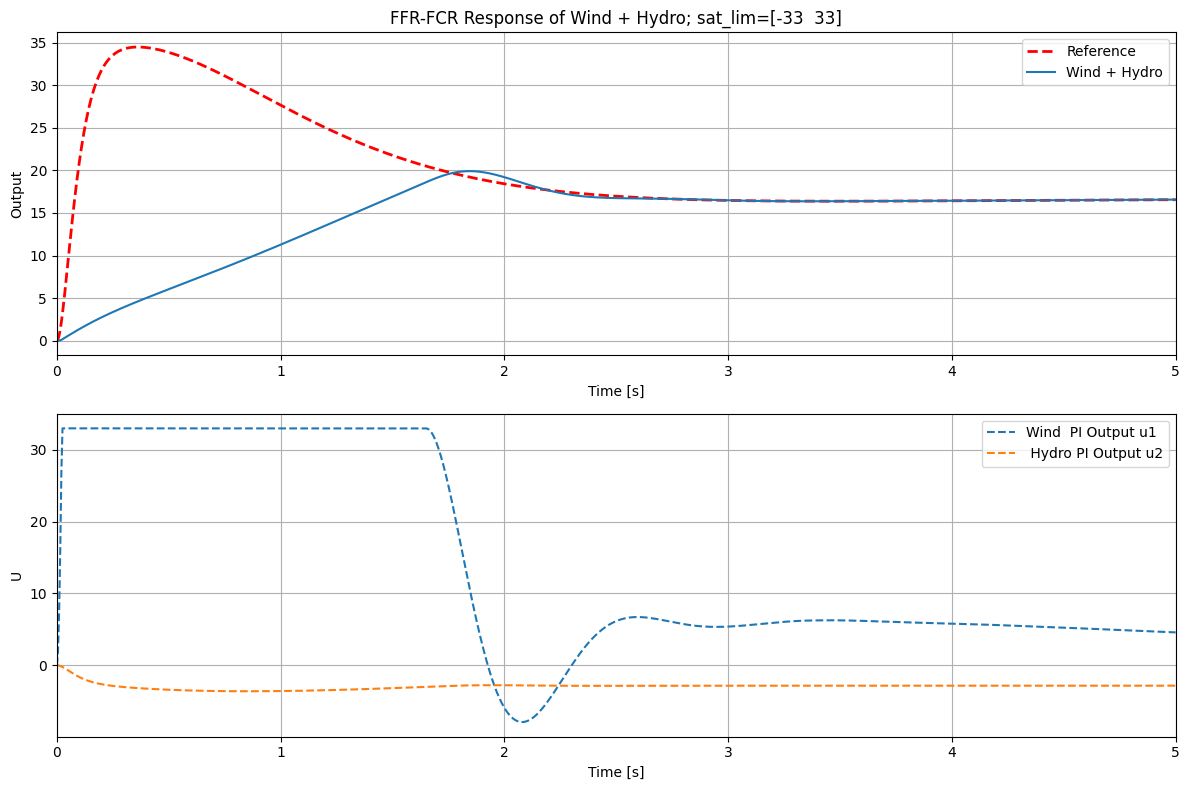

Metrics for Wind + Hydro:
Steady-state error: 0.0024
Settling time (2%): 1.52 seconds
Overshoot: 0.00%


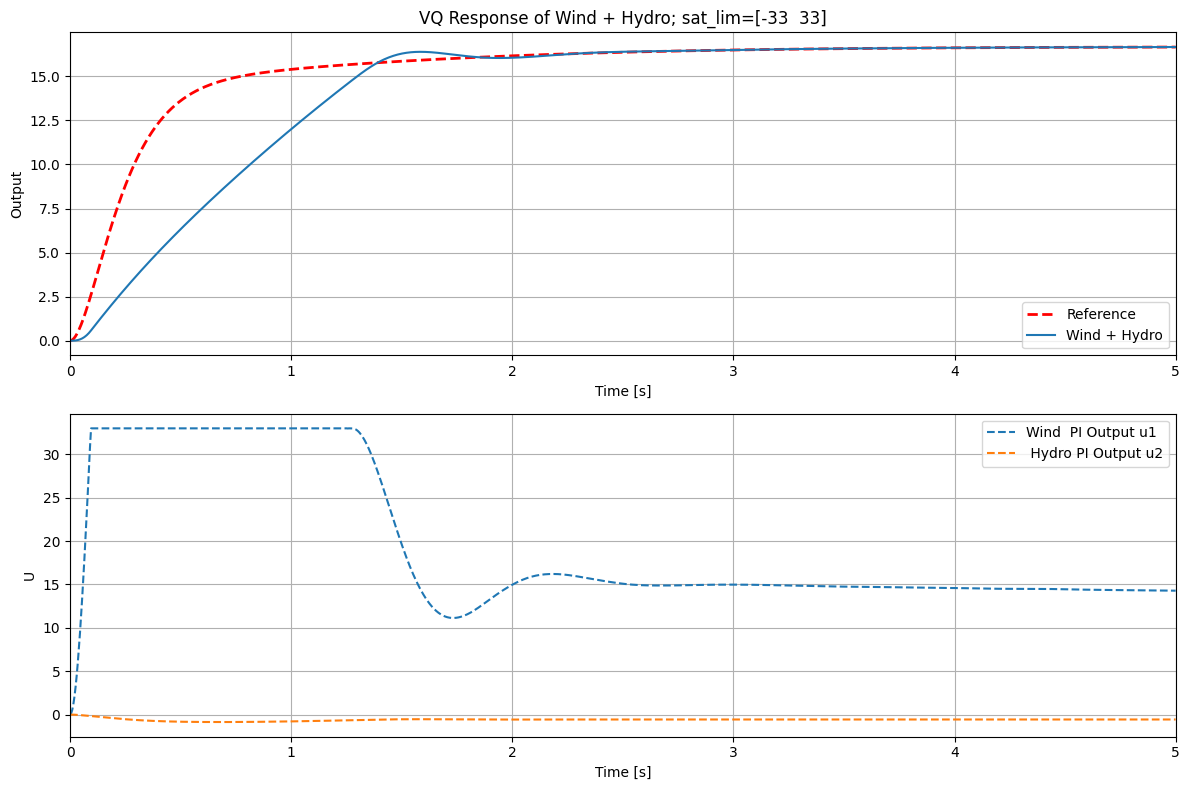

Metrics for BESS + Hydro:
Steady-state error: 0.0006
Settling time (2%): 2.55 seconds
Overshoot: 97.91%


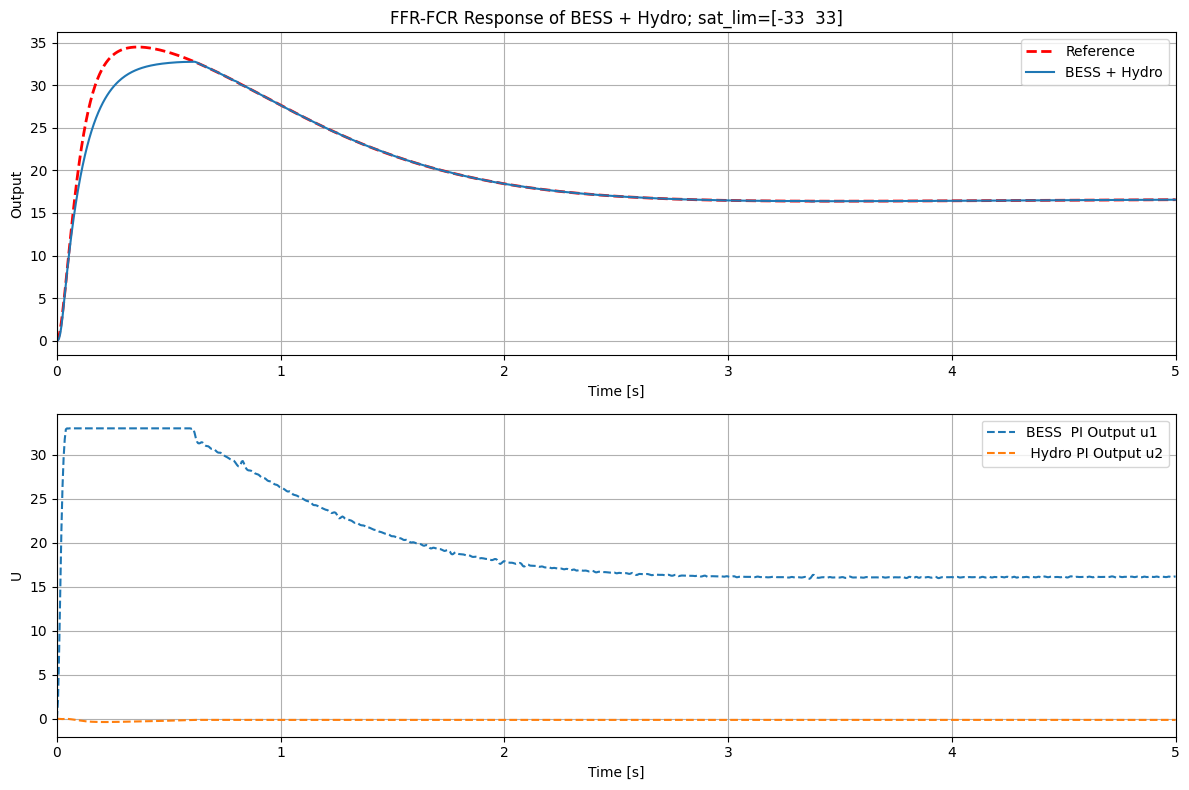

Metrics for BESS + Hydro:
Steady-state error: 0.0003
Settling time (2%): 2.39 seconds
Overshoot: 0.02%


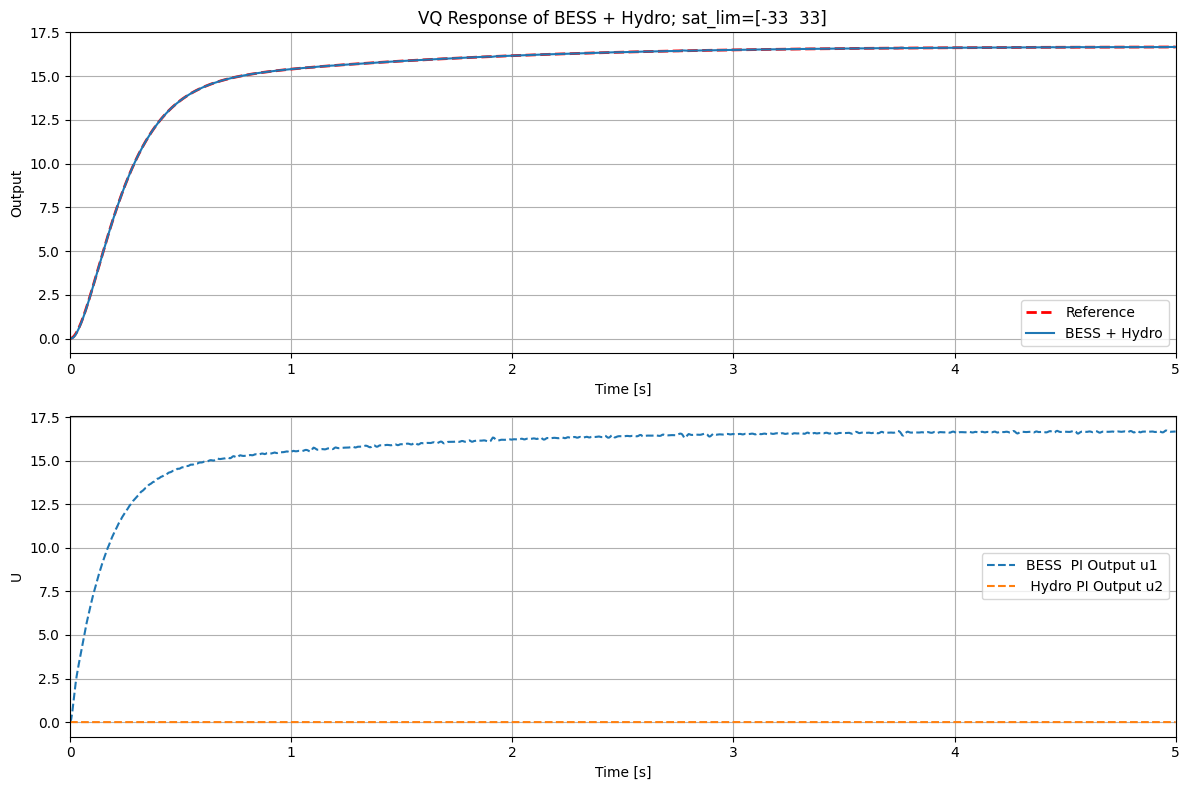

In [705]:
# aggregate 2 units for FFR-FCR and VQ
for subset in itertools.combinations(names, 2):
    name1, name2 = subset
    G1, G2 = Gs[name1], Gs[name2]
    # rename for new closed loop
    G1.output_labels = ['y1']
    G1.name = name1
    G2.output_labels = ['y2']
    G2.name = name2
    y_total = ct.summing_junction(['y1', 'y2'], 'y')  # create new total output
    error = ct.summing_junction(['yref', '-y'], 'e')  # error signal
    PI1, PI2 = PIs[name1], PIs[name2]  # get PI controller
    PI1.output_labels = ['u1']
    PI1.input_labels = ['e']
    PI1.name = f'PI_{name1}'
    PI2.output_labels = ['u2']
    PI2.input_labels = ['e']
    PI2.name = f'PI_{name2}'
    G1.input_labels = ['u1']
    G2.input_labels = ['u2']

    closed_loop_agg = ct.interconnect([PI1, PI2, G1, G2, y_total, error], inputs=['yref'], outputs=['y', 'u1', 'u2'])
    name_agg = f'{name1} + {name2}'

    check_control_system([closed_loop_agg], yffr_fcr_des, [name_agg], tlim=[0,5], title=f'FFR-FCR Response of {name_agg}; sat_lim={saturation_limits}')

    check_control_system([closed_loop_agg], yvq_des, [name_agg], tlim=[0,5], title=f'VQ Response of {name_agg}; sat_lim={saturation_limits}')

## Aggr. 3 units

C:\Users\carlv\AppData\Roaming\Python\Python311\site-packages\control\nlsys.py:1191: UserWarning: Unused input(s) in InterconnectedSystem: (9, 0)=sys[1422].u3; (4, 0)=BESS.u3
  warn(msg)


Metrics for PV + Wind + BESS:
Steady-state error: 0.0068
Settling time (2%): 0.41 seconds
Overshoot: 80.03%


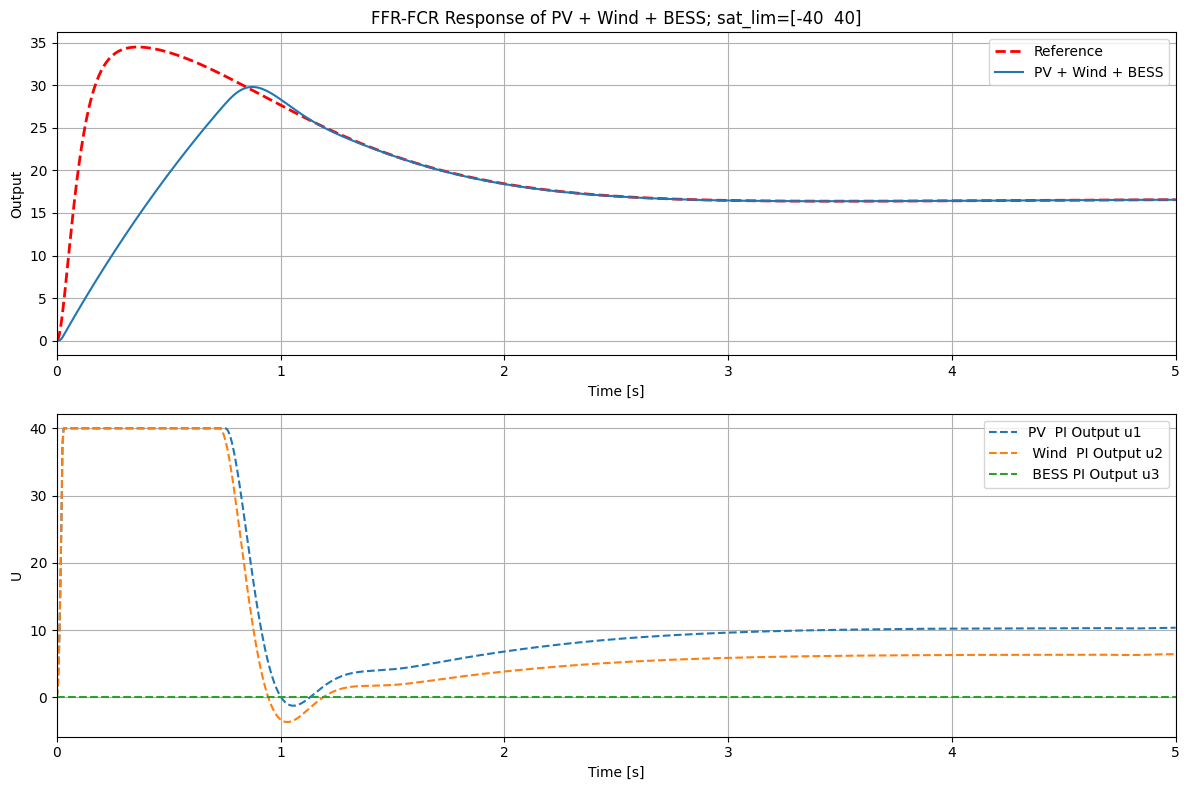

C:\Users\carlv\AppData\Roaming\Python\Python311\site-packages\control\nlsys.py:1191: UserWarning: Unused input(s) in InterconnectedSystem: (9, 0)=sys[1431].u3; (4, 0)=Hydro.u3
  warn(msg)


Metrics for PV + Wind + Hydro:
Steady-state error: 0.0044
Settling time (2%): 0.41 seconds
Overshoot: 80.00%


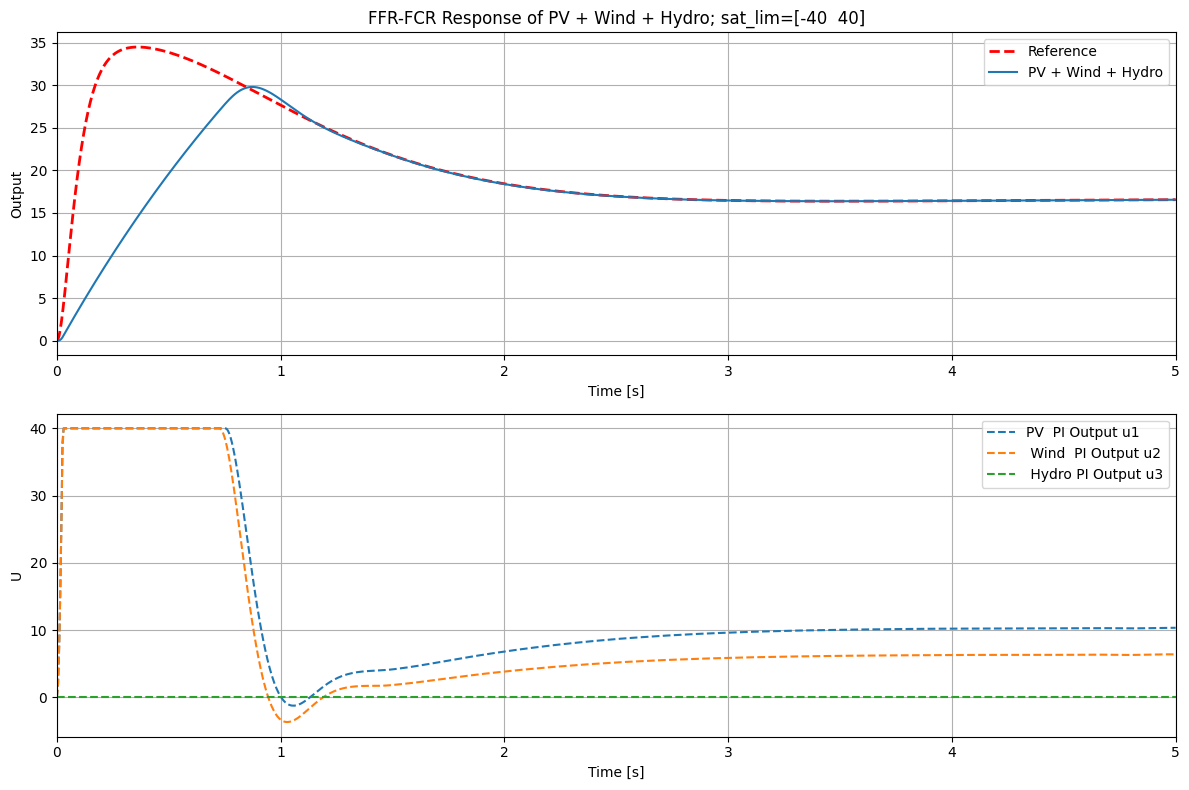

C:\Users\carlv\AppData\Roaming\Python\Python311\site-packages\control\nlsys.py:1191: UserWarning: Unused input(s) in InterconnectedSystem: (9, 0)=sys[1440].u3; (4, 0)=Hydro.u3
  warn(msg)


Metrics for PV + BESS + Hydro:
Steady-state error: 0.0029
Settling time (2%): 0.08 seconds
Overshoot: 108.28%


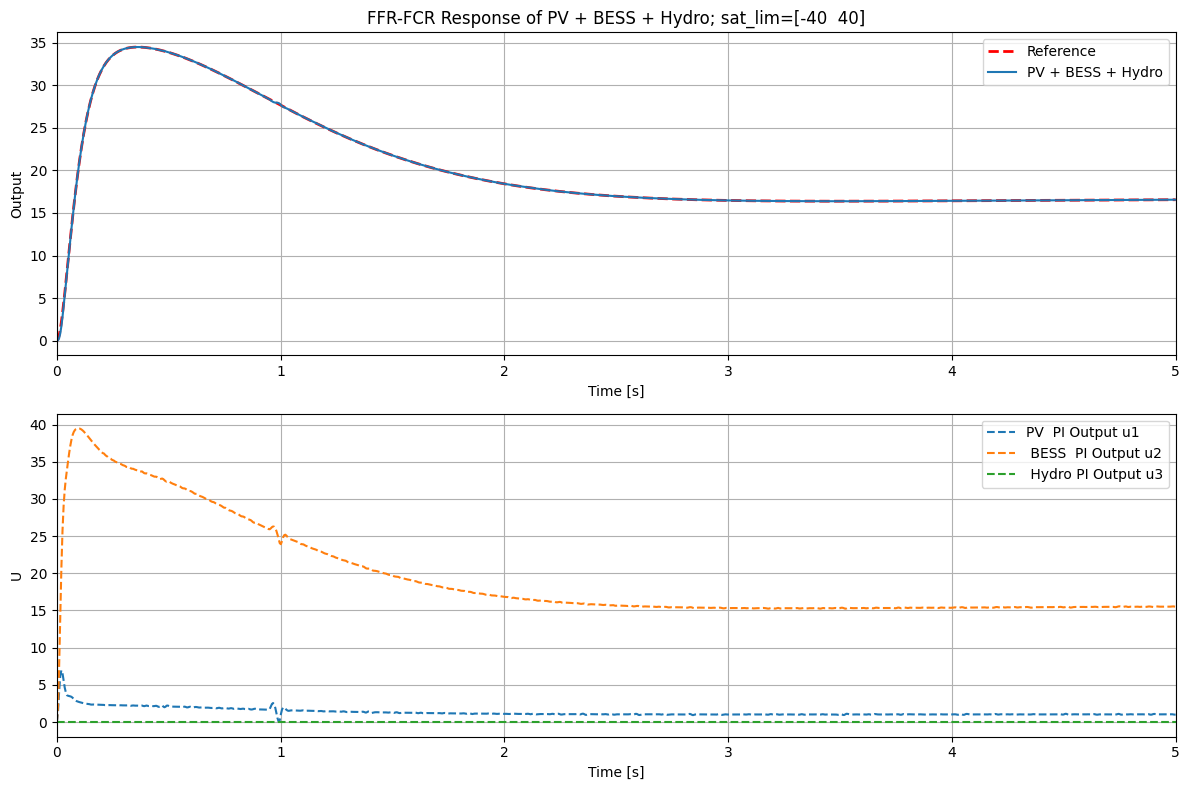

C:\Users\carlv\AppData\Roaming\Python\Python311\site-packages\control\nlsys.py:1191: UserWarning: Unused input(s) in InterconnectedSystem: (9, 0)=sys[1449].u3; (4, 0)=Hydro.u3
  warn(msg)


Metrics for Wind + BESS + Hydro:
Steady-state error: 0.0002
Settling time (2%): 0.08 seconds
Overshoot: 108.32%


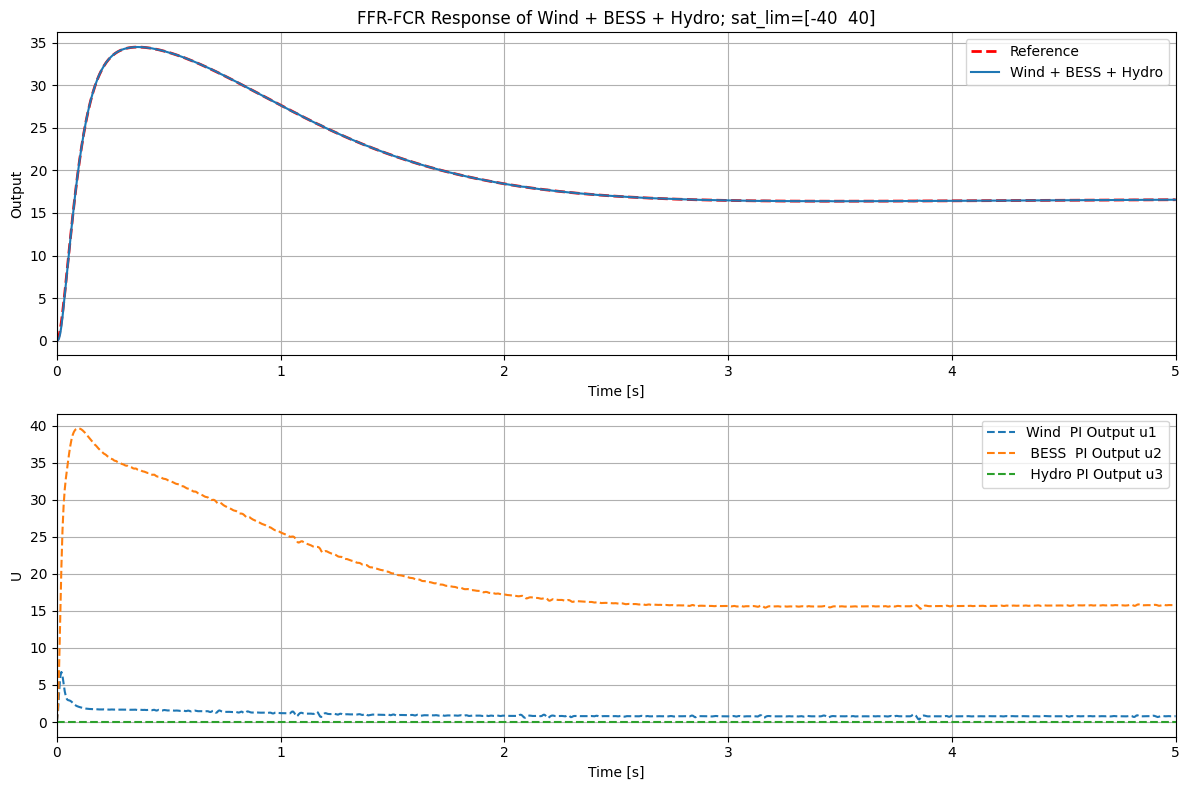

In [617]:
# aggregate 3 units
for subset in itertools.combinations(names, 3):
    name1, name2, name3 = subset
    G1, G2, G3 = Gs[name1], Gs[name2], Gs[name3]
    # rename for new closed loop
    G1.output_labels = ['y1']
    G1.name = name1
    G2.output_labels = ['y2']
    G2.name = name2
    G3.output_labels = ['y3']
    G3.name = name3
    y_total = ct.summing_junction(['y1', 'y2', 'y3'], 'y')  # create new total output
    error = ct.summing_junction(['yref', '-y'], 'e')  # error signal
    PI1, PI2, PI3 = PIs[name1], PIs[name2], PIs[name3]  # get PI controller
    PI1.output_labels = ['u1']
    PI1.name = f'PI_{name1}'
    PI2.output_labels = ['u2']
    PI2.name = f'PI_{name2}'
    PI3.output_labels = ['u3']
    PI3.name = f'PI_{name3}'
    G1.input_labels = ['u1']
    G2.input_labels = ['u2']
    G3.input_labels = ['u3']

    # define u, e as output as well
    u1_out = ct.summing_junction(['u1'], 'u1_out')
    u2_out = ct.summing_junction(['u2'], 'u2_out')
    u3_out = ct.summing_junction(['u3'], 'u3_out')

    closed_loop_agg = ct.interconnect([PI1, PI2, G1, G2, G3, y_total, error, u1_out, u2_out, u3_out], inputs=['yref'], outputs=['y', 'u1_out', 'u2_out', 'u3_out'])
    name_agg = f'{name1} + {name2} + {name3}'

    check_control_system([closed_loop_agg], yffr_fcr_des, [name_agg], tlim=[0,5], title=f'FFR-FCR Response of {name_agg}; sat_lim={saturation_limits}')